#**Computer Vision - Pneumonia detection on Chest Radiograph**

 - Data Scope : DICOM images for training from Kaggle then test images for predictions (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)
 - Objective : Learning all the key features from DICOM images and conduct a supervised learning with the labels associated with the images then predict the Pneumonia region(s) in the chest Radiograph images
 - Domain Value: AI driven diagnosis for Pneumonia infection

## Setting up Google Drive access authentication

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path='/content/drive/My Drive/Colab Notebooks/MSDS_CV_FinalProject'

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/Data/Pneumonia-Capstone'

## Installing pydicom & deid for reading DICOM images

In [ ]:
pip install deid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.2 MB 105.0 MB/s 
     |████████████████████████████████| 1.9 MB 73.9 MB/s 
  Created wheel for deid: filename=deid-0.2.29-py3-none-any.whl size=27231749 sha256=cb01c14f058d6f498a804f9073fa3dc342a4b35e545b66afd0048e9e7085681d
  Stored in directory: /root/.cache/pip/wheels/cf/ad/16/03b4039046048494246ddaf74ac356014e401cbda3b86a090c
Successfully built deid


In [ ]:
from deid.dicom import get_files

## Importing the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import pydicom
from pydicom import dcmread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
%matplotlib inline
import cv2 as cv
import tensorflow as tf
import keras
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50,resnet_v2
from keras.layers import Dense, GlobalAveragePooling2D,Flatten, Conv2D , MaxPool2D  , Dropout , BatchNormalization,Activation,ActivityRegularization,Layer,TimeDistributed
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision,Recall,categorical_crossentropy,SpecificityAtSensitivity,mae
from keras.losses import mean_squared_error,mse,mae,categorical_crossentropy
from keras import callbacks
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix,precision_recall_curve,roc_curve,auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical
from keras.models import load_model
import itertools 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import cv2
import random
import time
from keras  import Input
from keras import backend as K
from keras.utils import generic_utils
from tensorflow.keras.layers import Layer
from keras import initializers, regularizers
import math
import copy
from copy import deepcopy

## Loading labels and data

In [ ]:
train_labels = pd.read_csv(data_path+'/stage_2_train_labels.csv')
train_class = pd.read_csv(data_path+'/stage_2_detailed_class_info.csv')

In [ ]:
train_data = pd.merge(train_class, train_labels, left_index=True, right_index=True)
train_data.drop(columns ={'patientId_y'},inplace=True)
train_data.rename(columns={'patientId_x':'patientId'},inplace=True)

In [ ]:
train_data.shape

(30227, 7)

In [ ]:
train_data[train_data.duplicated()].sort_values(by=['patientId'])

,patientId,class,x,y,width,height,Target


In [ ]:
train_data_0 = train_data[train_data['Target']==0].copy()
train_data_1 = train_data[train_data['Target']==1].copy()
train_data_0 = train_data_0.reset_index(drop=True)
train_data_1 = train_data_1.reset_index(drop=True)

In [ ]:
batch_names =['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']
x_1=0
y_1=1000 # There are 9555 Pneumonia infected samples so approx 1000 per batch for 10 batches overall
x_0=0
y_0=2068 # There are 20672 samples as records with no pneumonia infection, so approx 2068 per batch for 10 batches overall
for x in batch_names:
    exec('{} = (train_data_1.iloc[{}:{}]).append(train_data_0.iloc[{}:{}]).reset_index(drop=True)'.format(x,x_1,y_1,x_0,y_0))
    x_1=y_1
    y_1=y_1+1000
    x_0=y_0
    y_0=y_0+2068

In [ ]:
X1.head()

,patientId,class,x,y,width,height,Target
0,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
1,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
2,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,323.0,577.0,160.0,104.0,1
3,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,695.0,575.0,162.0,137.0,1
4,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,288.0,322.0,94.0,135.0,1


## Build Image Classification and Object Detection Models for Pneumonia classification, region detection and prediction with bounding boxes

### Solution Intent & Approach
  - A computer vision model to differentiate Pneumonia and Non-Pneumonia Chest Radiographs i.e. Classifying Pneumonia and Normal
  - Object detection model to predict the impacted regions on the chest radiographs for Pneumonia
  - Train the model of various images (with various patterns) in order to bring up a very good accuracy in both classification and impact region detection
  - Samples taken across the training data set of about 3000 patients with a close proportions of Normal and Pneumonia
  - Validation set will be of 20% of the training set, rest will be used for training
  - ResNet pretrained model will be used for classification, weights will be initialized with imagenet weights
  - Evaluate and fine tune the classification model to provide the best accuracy
  - Tabularize the classification report, charts and metrics
  - Faster RCNN with ResNet pretrained model as the backbone for object classification and detection
  - Both classification and object detection Models and weights will be saved in local disk for using it later for test data
  - Evaluate and Finetune the model till we get the desired accuracy
  - For deployment, pipeline will be used to preprocess the image then classification model and filter only the pneumonia infected images then feed them only to Faster RCNN trained model for Pneumonia detection
  - Techniques used: Keras library, sampling, preprocessing, Image data generator, resnet50, faster RCNN,batch normalization, dense and flatten layers, global average pooling, loss function for back propagation (binary cross entropy), metrics such as binary accuracy, recall & precision ,standard scaler for normalizing the data, train and validation split, model sequential, convolution and pooling,region proposal network, Region Of interest pooling, anchors

#### Why ResNet as the classification backbone model

 - Residual (the difference between the actual and the predicted) will be treated through back propagation in order to meet the accuracy
 - Accuracy is so critical in both normal and Pneumonia cases due to the severity of Pneumonia infection
 - As we learn deeper about image layers, the accuracy won't degrade by the capability of ResNet

#### Why Faster RCNN
  - There is no selective search of features rather running the images through a CNN (ResNet here) to get a feature map
  - Run activation through a network called Region Proposal Network (RPN). that output interesting boxes/regions (Pneumonia regions)
  - For the interesting boxes/regions from RPN use several fully connected layer to output class + Bounding Box coordinates
  - Basically, Faster RCNN is composed of two different networks: the Region Proposal Network which does the proposals, and the Evaluation Network which takes the proposals and evaluates classes/bbox 

#### How Faster RCNN Works
 - ***Feature Map:*** Extracting the feature map from CNN backbone (Resnet) then feed the feature map to Region proposal network along with anchor boxes
 - ***Anchors:*** Box designed to propose region boxes (proposed Pneumonia impacted regions) by comparing the overlap with ground truth boxes (actual Pneumonia impact regions from training data). These boxes will help to capture capture the scale and aspect ratio of the objects to be detected
 - Anchor will have two possible labels such as foreground and background of the feature map predicted by RPN (***Region Proposal network***)
 - The basic idea here is that we want to label the anchors having the higher overlaps with ground-truth boxes as foreground, the ones with lower overlaps as background
 - Proposed regions by RPN will be done with ***RoI pooling*** to get almost equal sizes of each proposed region
 - ***Classifier*** will classify in the proposed regions as objects or backgrounds
 - ***Regressor*** will refine the bounding boxes in the proposed region (for the detected objects)

#### Architecture prototype Design Decisions
  - Data augmentation with image shaping to 224, image horizontal, vertical flips, rotate by 30 degree, Zoom by 25%
  - Transfer learning technique has been for feature learning. ResNet has been the one chosen for the prototype
  - Weights are initialized with pretrained imagenet weights then fine tuned to the appropriate ones
  - ResNet base model will be used to extract the feature Map
  - Anchor - 9 anchors with 112 X 112 size each and stride 16
  - Faster RCNN will be the architecture for object classification and boundary box detection

#### Import the required libraries

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import resnet50
from keras.layers import Dense, GlobalAveragePooling2D,Flatten, Conv2D , MaxPool2D  , Dropout , BatchNormalization
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.metrics import Precision,Recall,categorical_crossentropy
from keras import callbacks
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix,precision_recall_curve,roc_curve,auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical
from keras.models import load_model
import itertools 

### Custom Functions - For use during data generation, model building, compile, training, validation and test

In [ ]:
def extract_batch_DICOM_image_Data(batch_files,img_size):
  data = pd.DataFrame(columns=['patientId','Img_data','Age', 'Sex', 'Modality','Examined','ViewPosition'])
  for i,row in enumerate(batch_files):
    img_data = dcmread(row)
    image = cv.resize(np.array(img_data.pixel_array), (img_size,img_size))
    data.loc[i,'patientId'] = img_data.PatientID
    data.loc[i,'Img_data'] = image
    data.loc[i,'Age']      = img_data.PatientAge
    data.loc[i,'Sex'] = img_data.PatientSex
    data.loc[i,'Modality'] = img_data.Modality
    data.loc[i,'Examined'] = img_data.BodyPartExamined  
    data.loc[i,'ViewPosition']  = img_data.ViewPosition
  return data

In [ ]:
def standardize_split(X_batch,n_classes):
  X = (np.array([img_to_array(load_img(img, target_size=(224, 224))) for img in X_batch['image_path'].values.tolist()]).astype('float32'))/255.0
  y = X_batch['Target'].values.reshape((len(X_batch), 1))
  y = to_categorical(y, num_classes=n_classes)
  X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=np.array(y), random_state=1)
  return X_train, X_validation, y_train, y_validation

In [ ]:
## Function to display image
def display_image(img_array_list,label_list):
    counter=0
    height = 2.5*len(label_list)
    plt.figure(figsize=(10,height))
    for image in img_array_list:
        rows=len(label_list)//2 if len(label_list)>1 else 1
        plt.subplot(rows+1,2,counter+1)
        plt.imshow(image, interpolation='nearest')
        label=np.argmax(label_list[counter])
        if label==0:
            title="Lung Opacity"
        elif label==1:
            title='No Lung Opacity but not normal'
        else:
            title ='Normal'
        plt.title(title)
        counter+=1
    plt.show()

In [ ]:
def train_vs_val_charts(model,history,val_gen):
  fig, ax = plt.subplots(1, 5, figsize=(20, 3))
  ax = ax.ravel()

  for i, met in enumerate([ 'precision', 'recall','accuracy', 'loss','specificity']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
  loss, acc, prec, rec,spec= model.evaluate_generator(val_gen)
  print('Validation Evaluation Summary - Accuracy:{} Precision:{} Recall:{} Loss:{} Specificity:{}'.format(acc,prec,rec,loss,spec))

In [ ]:
def pred_class(y_pred):
  val=0.0
  max_ele =0
  y_pred_updated=y_pred.copy()
  for i,row in enumerate(y_pred):
    for j,ele in enumerate(row):
      if(ele > val):
        max_ele=j
        val = ele
    for j,ele in enumerate(row):
       if j == max_ele:
         y_pred_updated[i][j]=1.0
       else:
         y_pred_updated[i][j]=0.0
    val=0.0
  return y_pred_updated

In [ ]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
  plt.figure(figsize=(8,8))
  plt.title(title)
  sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=cmap)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [ ]:
def perf_model(y_actual,y_hat,class_name):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    #print('Class {} TP:{} FP:{} TN:{} FN:{}'.format(class_name,TP, FP, TN, FN))
    return TP,FP,TN,FN

In [ ]:
def perf_score(y_validation,predictions):
  p_TP,p_FP,p_TN,p_FN=perf_model(y_validation[:,1],predictions[:,1],'Pneumonia')
  nn_TP,nn_FP,nn_TN,nn_FN=perf_model(y_validation[:,1],predictions[:,1],'No Lung Opacity/Not Normal')
  n_TP,n_FP,n_TN,n_FN=perf_model(y_validation[:,0],predictions[:,0],'Normal')
  print(pd.DataFrame({'Pneumonia':[p_TP,p_FP,p_TN,p_FN],
              'No Lung Opacity/Not Normal':[nn_TP,nn_FP,nn_TN,nn_FN],
              'Normal':[n_TP,n_FP,n_TN,n_FN]              
              },index=['True Positive','False Positive','True Negative','False Negative']))

In [ ]:
def plot_precision_recall_curve(y_pred, y,n_classes):
  precision = dict()
  recall = dict()
  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("precision vs. recall curve")
  plt.show()

In [ ]:
def gen_precision_recall(n_classes,y,y_pred):
  p =dict()
  r = dict()
  thresholds =dict()
  for i in range(n_classes):
    p[i], r[i], thresholds[i] = precision_recall_curve(y[:, i],y_pred[:, i])
  return p,r,thresholds

In [ ]:
def plot_roc_curve(y,y_pred,n_classes):
  fpr = dict()
  tpr = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i],y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {} - auc score {}'.format(i,round(auc(fpr[i], tpr[i]),2)))

  plt.xlabel("false positive rate")
  plt.ylabel("true positive rate")
  plt.legend(loc="best")
  plt.title("ROC curve")
  plt.show()

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds,n_classes):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    prec_color=['b--','y--','o--']
    rec_color=['g-','r-','p-']
    for i in range(n_classes):
        plt.plot(thresholds[i], precisions[i][0:-1], prec_color[i], label='class {} Precision'.format(i))
        plt.plot(thresholds[i], recalls[i][0:-1], rec_color[i], label='class {} Recall'.format(i))
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
def plot_aug_img_bbox(img_data,resized_img_rsize, resized_img_csize,org_img_rsize,org_img_csize):
  assert 'image_path' in img_data
  assert 'x' in img_data
  assert 'y' in img_data
  assert 'width' in img_data
  assert 'height' in img_data
  img_data_aug = img_data.copy()
  fig, ax = plt.subplots(2,2, figsize=(14,18))
  img = np.array(img_to_array(load_img(str(img_data_aug['image_path']),target_size=(resized_img_rsize, resized_img_csize))).astype('float32'))/255.0

  # scale x,y,width and height
  #scale_x = (resized_img_rsize*img_data_aug['x'])/org_img_rsize
  #scale_y = (resized_img_csize*img_data_aug['y'])/org_img_csize
  #scale_width = (resized_img_rsize*img_data_aug['width'])/org_img_rsize
  #scale_height = (resized_img_csize * img_data_aug['height'])/org_img_csize
  scale_x =img_data_aug['x']
  scale_y = img_data_aug['y']
  scale_width = img_data_aug['width']
  scale_height = img_data_aug['height']
  # Construct Image Plot blocks
  ax[1//2,0%2].imshow(img,cmap = plt.cm.bone) # Original Image
  rectangle = patches.Rectangle(xy=(scale_x, scale_y),
                        width=scale_width,height=scale_height, 
                        color="yellow",fc='none',ec='r', lw=4)
  ax[1//2,0%2].add_patch(rectangle)

  img1 = cv2.flip(img, 1) 
  ax[1//2,1%2].imshow(img1,cmap = plt.cm.bone)
  rectangle = patches.Rectangle(xy=(resized_img_csize-(scale_x+scale_width), scale_y),  # Image shape (Column size - (x+width)) for horizontal flip
                        width=scale_width,height=scale_height, 
                        color="yellow",fc='none',ec='r', lw=4)
  ax[1//2,1%2].add_patch(rectangle)

  img2 = cv2.flip(img, 0)
  ax[2//2,0%2].imshow(img2, cmap = plt.cm.bone)
  rectangle = patches.Rectangle(xy=(scale_x, resized_img_rsize-(scale_y+scale_height)),  # Image shape (row size - (y+height)) for vertical flip
                        width=scale_width,height=scale_height, 
                        color="yellow",fc='none',ec='r', lw=4)
  ax[2//2,0%2].add_patch(rectangle)


  img3 = np.transpose(img, (1,0,2))
  img4 = cv2.flip(img3, 1)
  ax[2//2,1%2].imshow(img4, cmap = plt.cm.bone)
  rectangle = patches.Rectangle(xy=(resized_img_rsize-(scale_y+scale_height),scale_x),   # 90 deg rotation
                        width=scale_height,height=scale_width, 
                        color="yellow",fc='none',ec='r', lw=4)
  ax[2//2,1%2].add_patch(rectangle)

  plt.show()

In [ ]:
def show_pneumonia_boxes(x):
    
    data_dict = list(x.T.to_dict().values())
    fig, ax = plt.subplots(3,2, figsize=(14,18))
    for i, row in enumerate(data_dict):
        #img_data = (np.array([img_to_array(load_img(img, target_size=(224, 224))) for img in x['image_path'].values.tolist()]).astype('float32'))/255.0
        img_data = np.array(img_to_array(load_img(row['image_path'],target_size=(224, 224))).astype('float32'))/255.0
        ax[i//2,i%2].imshow(img_data, cmap = plt.cm.bone)
        ax[i//2,i%2].axis('off')
        ax[i//2,i%2].set_title('ID: {}'.format(row['patientId']))
        # overlay the bounding box
        records = x[x['patientId']==row['patientId']]
        bounding_box = list(records.T.to_dict().values())
        for j, record in enumerate(bounding_box):
            rows, cols = img_data.shape[:2]
            rectangle = patches.Rectangle(xy=((224*record['x'])/1024, (224*record['y'])/1024),
                        width=(224*record['width'])/1024,height=(224 * record['height'])/1024, 
                        color="yellow",fc='none',ec='r', lw=4)
            ax[i//2,i%2].add_patch(rectangle)
    plt.show()

In [ ]:
def paint_bbox_pred(img_data):
  
  data_dict = list(img_data.T.to_dict().values())
  fig, ax = plt.subplots(3,2, figsize=(6,8))
  for i, row in enumerate(data_dict):
    img = np.array(img_to_array(load_img(row['img_path'],target_size=(224, 224))).astype('float32'))/255.0
    ax[i//2,i%2].imshow(img,cmap = plt.cm.bone) # Original Image
    #print('ROI.shape[0]=',R.shape[1])
    #print(row['bboxes']['background'])
    if row['bboxes'].get('Lung Opacity')!=None:
      for j,subrow in enumerate(row['bboxes']['Lung Opacity']):
        #print(subrow)
        #if i==0:
        #x,y,w,h = subrow[0],subrow[1],subrow[2],subrow[3]
        x1,y1,x2,y2 = subrow[0],subrow[1],subrow[2],subrow[3]
        #print(x1,y1,x2,y2)
        rectangle = patches.Rectangle(xy=(x1, y1),
                          width=(x2-x1),height=(y2-y1), 
                          #width=w,height=h,
                          color="yellow",fc='none',ec='r', lw=4)
        ax[i//2,i%2].add_patch(rectangle)
    
    
  plt.show()

### Pneumonia Patients Classification Model Training and Validation

#### Preparing Data of 5 batches for the classification model

In [ ]:
X1_files = list(get_files(data_path+"/X1"))
X2_files = list(get_files(data_path+"/X2"))
X3_files = list(get_files(data_path+"/X3"))
X4_files = list(get_files(data_path+"/X4"))
X5_files = list(get_files(data_path+"/X5"))

In [ ]:
X1_DICOM_metadata = extract_batch_DICOM_image_Data(X1_files,224)
X2_DICOM_metadata = extract_batch_DICOM_image_Data(X2_files,224)
X3_DICOM_metadata = extract_batch_DICOM_image_Data(X3_files,224)
X4_DICOM_metadata = extract_batch_DICOM_image_Data(X4_files,224)
X5_DICOM_metadata = extract_batch_DICOM_image_Data(X5_files,224)

In [ ]:
X_X1 = pd.merge(X1,X1_DICOM_metadata,how='inner', on='patientId')
X_X2 = pd.merge(X2,X2_DICOM_metadata,how='inner', on='patientId')
X_X3 = pd.merge(X3,X3_DICOM_metadata,how='inner', on='patientId')
X_X4 = pd.merge(X4,X4_DICOM_metadata,how='inner', on='patientId')
X_X5 = pd.merge(X5,X5_DICOM_metadata,how='inner', on='patientId')

In [ ]:
X_X1.to_csv(data_path+'/X_X1.csv')
X_X2.to_csv(data_path+'/X_X2.csv')
X_X3.to_csv(data_path+'/X_X3.csv')
X_X4.to_csv(data_path+'/X_X4.csv')
X_X5.to_csv(data_path+'/X_X5.csv')

In [ ]:
X_X1 = pd.read_csv(data_path+'/X_X1.csv',index_col=0)
X_X2 = pd.read_csv(data_path+'/X_X2.csv',index_col=0)
X_X3 = pd.read_csv(data_path+'/X_X3.csv',index_col=0)
X_X4 = pd.read_csv(data_path+'/X_X4.csv',index_col=0)
X_X5 = pd.read_csv(data_path+'/X_X5.csv',index_col=0)

In [ ]:
### Picking up 5 different batches of image set having 9000 images for training and validation purpose
img_folders = [data_path+'/X1_JPG/',data_path+'/X2_JPG/',data_path+'/X3_JPG/',data_path+'/X4_JPG/',data_path+'/X5_JPG/']
X=pd.DataFrame()
counter=0
for img_folder in img_folders:
  counter+=1
  globals()['X_X'+str(counter)]['image_path'] = globals()['X'+str(counter)].apply( lambda x: (img_folder + x["patientId"] + ".jpg" ), axis=1)

In [ ]:
X_X1.iloc[0,:]['image_path']

'/content/drive/My Drive/Colab Notebooks/Data/Pneumonia-Capstone/X1_JPG/00436515-870c-4b36-a041-de91049b9ab4.jpg'

In [ ]:
X_X2.iloc[0,:]['image_path']

'/content/drive/My Drive/Colab Notebooks/Data/Pneumonia-Capstone/X2_JPG/31102758-a5ba-44c9-b480-b744bcfcb861.jpg'

In [ ]:
X = X_X1.append([X_X2,X_X3,X_X4,X_X5])

In [ ]:
labelencoder = LabelEncoder()
X['class_encoded']= labelencoder.fit_transform(X['class'])

In [ ]:
X[X['class_encoded']==0].head(2)

,patientId,class,x,y,width,height,Target,Img_data,Age,Sex,Modality,Examined,ViewPosition,image_path,class_encoded
0,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,[[2 3 3 ... 3 3 3]\n [3 3 3 ... 3 3 3]\n [2 3 ...,32,F,CR,CHEST,AP,/content/drive/My Drive/Colab Notebooks/Data/P...,0
1,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,[[2 3 3 ... 3 3 3]\n [3 3 3 ... 3 3 3]\n [2 3 ...,32,F,CR,CHEST,AP,/content/drive/My Drive/Colab Notebooks/Data/P...,0


In [ ]:
X[X['class_encoded']==1].head(2)

,patientId,class,x,y,width,height,Target,Img_data,Age,Sex,Modality,Examined,ViewPosition,image_path,class_encoded
1000,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,[[ 82 39 20 ... 66 111 169]\n [ 24 8 2 ...,51,F,CR,CHEST,PA,/content/drive/My Drive/Colab Notebooks/Data/P...,1
1001,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,[[ 17 1 0 ... 65 85 99]\n [ 16 0 0 ...,48,F,CR,CHEST,PA,/content/drive/My Drive/Colab Notebooks/Data/P...,1


In [ ]:
X[X['class_encoded']==2].head(2)

,patientId,class,x,y,width,height,Target,Img_data,Age,Sex,Modality,Examined,ViewPosition,image_path,class_encoded
1003,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,[[203 200 193 ... 217 227 230]\n [152 125 112 ...,28,M,CR,CHEST,PA,/content/drive/My Drive/Colab Notebooks/Data/P...,2
1007,009482dc-3db5-48d4-8580-5c89c4f01334,Normal,NaN,NaN,NaN,NaN,0,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,63,M,CR,CHEST,PA,/content/drive/My Drive/Colab Notebooks/Data/P...,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


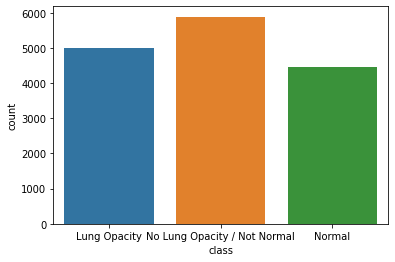

In [ ]:
sns.countplot(X['class'])

Labels: 
- 0:Lung Opacity
- 1: Lung Opacity but not normal
- 2:Normal

In [ ]:
X_train, X_validation, y_train, y_validation= standardize_split(X,2)

In [ ]:
X_train.shape,y_train.shape,X_validation.shape,y_validation.shape

((12272, 224, 224, 3), (12272, 2), (3068, 224, 224, 3), (3068, 2))

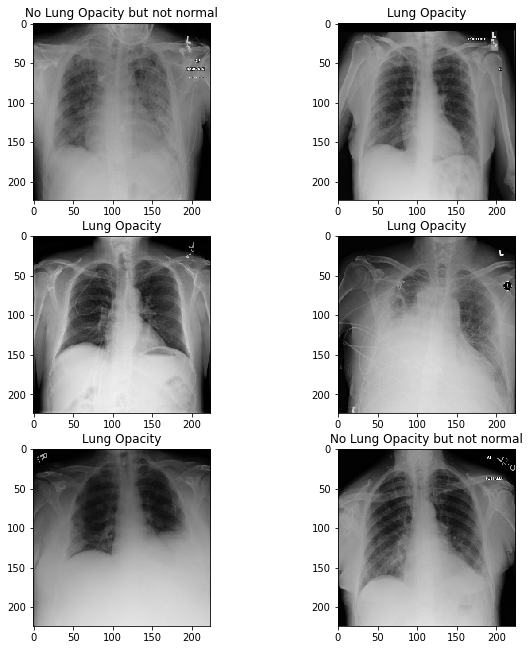

In [ ]:
display_image([X_train[0],X_train[10],X_validation[1200],X_validation[800],X_validation[600],X_validation[200]],\
              [y_train[0],y_train[10],y_validation[1200],y_validation[800],y_validation[600],y_validation[200]])

In [ ]:
X_pickle = open(data_path+'/X_batch','wb')
pickle.dump(X,X_pickle)
X_pickle.close()

In [ ]:
X = open(data_path+'/X_batch','rb')
X= pickle.load(X)

#### Classification Model

In [ ]:
class classifier():
    def __init__(self):
        self.epochs =  100
        self.drop_out = 0.5
        self.lr = 1e-4
        self.img_height = 224
        self.img_width = 224
        self.output_class = 2
        self.channel = 3
        self.lr_patience = 10
        self.es_patience = 15
        self.lr_factor = 0.4
        self.loss = 'val_loss'
        self.min_lr = 1e-6
        self.sensitivity = 0.8
        self.batch_size=32
        self.rot_range=30
        self.h_shift=0.05
        self.w_shift=0.05
        self.brightness=[0.2,0.8]
        self.hor_flip=True
        self.vert_flip=True
        self.zoom=0.05
        

    def img_classifier_build(self,train_gen,val_gen):
        base_model = resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (self.img_height,self.img_width,self.channel))
        x = base_model.output
        x = Conv2D(1024,(1,1))(x)
        x = Dropout(self.drop_out)(x)
        x = BatchNormalization()(x)
        x = Dense(256, activation ='relu') (x)
        x = Dense(128, activation ='relu') (x)
        x = BatchNormalization()(x)
        x = Flatten()(x)
        classifiers = Dense(self.output_class, activation='softmax')(x)
        model = Model(inputs = base_model.input, outputs = classifiers)
        optimizer = Adam(learning_rate=self.lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'),Recall(name='recall'),SpecificityAtSensitivity(self.sensitivity,name='specificity')])
        reduce_lr = ReduceLROnPlateau(monitor=self.loss, factor=self.lr_factor,patience=self.lr_patience, min_lr=self.min_lr)
        early_stopping = EarlyStopping(monitor=self.loss, patience=self.es_patience)
        history = model.fit(train_gen,
                        epochs=self.epochs, 
                        verbose=1,
                        validation_data=val_gen,
                        callbacks=[reduce_lr,early_stopping])
        return history,model
    
    def img_data_generator(self,X,y):
        img_gen=ImageDataGenerator(
            featurewise_center=False, samplewise_center=False,
            featurewise_std_normalization=False, samplewise_std_normalization=False,
            zca_whitening=False, rotation_range=self.rot_range, width_shift_range=self.w_shift,
            height_shift_range=self.h_shift, brightness_range=self.brightness, shear_range=0.0, zoom_range=self.zoom,
            channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
            horizontal_flip=self.hor_flip, vertical_flip=self.vert_flip,
            preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
          )
        data=img_gen.flow(X, y, shuffle=False, batch_size=self.batch_size, seed=1)
        return data

In [ ]:
classifier= classifier()

In [ ]:
train_gen = classifier.img_data_generator(X_train,y_train)

In [ ]:
val_gen = classifier.img_data_generator(X_validation,y_validation)

In [ ]:
history,model= classifier.img_classifier_build(train_gen,val_gen)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/100
384/384 [==============================] - 216s 511ms/step - loss: 0.6136 - accuracy: 0.7317 - precision: 0.7317 - recall: 0.7317 - specificity: 0.6584 - val_loss: 0.5265 - val_accuracy: 0.7885 - val_precision: 0.7885 - val_recall: 0.7885 - val_specificity: 0.7744 - lr: 1.0000e-04
Epoch 2/100
384/384 [==============================] - 197s 513ms/step - loss: 0.4644 - accuracy: 0.7929 - precision: 0.7929 - recall: 0.7929 - specificity: 0.7840 - val_loss: 0.4307 - val_accuracy: 0.8077 - val_precision: 0.8077 - val_recall: 0.8077 - val_specificity: 0.8126 - lr: 1.0000e-04
Epoch 3/100
384/384 [==============================] - 197s 512ms/step - loss: 0.4375 - accuracy: 0.8080 - precision: 0.8080 - recall: 0.8080 - specificity: 0.8159 - val_loss: 0.4049 - val_accuracy: 0.8178 - val_precision: 0.8178 - val_recall: 0.8178 - val_specificity: 0.8357 - lr: 1.0000e-04
Epoch 4/100
384/384 [==============================] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  if sys.path[0] == '':


Validation Evaluation Summary - Accuracy:0.8455019593238831 Precision:0.8455019593238831 Recall:0.8455019593238831 Loss:0.3802162706851959 Specificity:0.8719035387039185


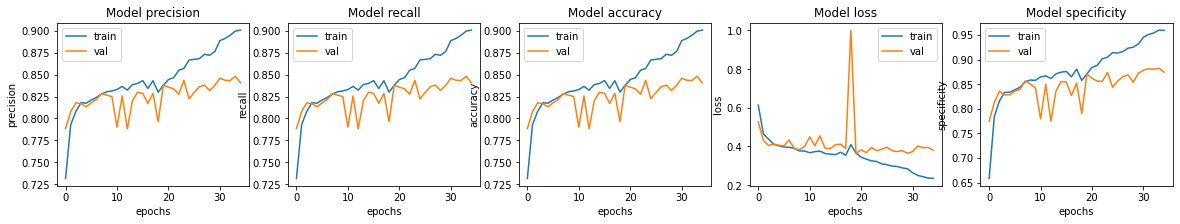

In [ ]:
train_vs_val_charts(model,history,val_gen)

In [ ]:
y_pred = model.predict_generator(val_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
predictions = pred_class(y_pred)

In [ ]:
cm = confusion_matrix(y_validation.argmax(axis=1),predictions.argmax(axis=1))

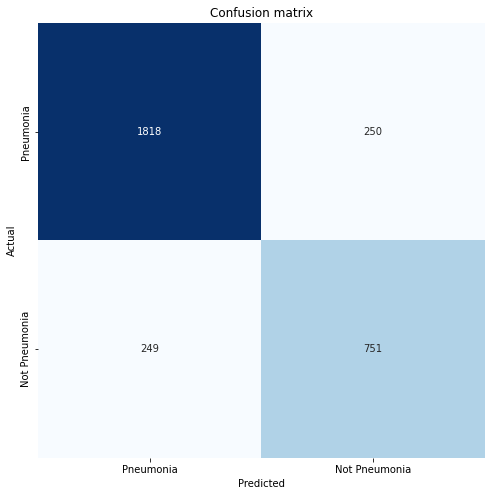

In [ ]:
plot_confusion_matrix(cm,['Pneumonia', 'Not Pneumonia'])

In [ ]:
perf_score(y_validation,predictions)

                Pneumonia  No Lung Opacity/Not Normal  Normal
True Positive         751                         751    1818
False Positive        250                         250     249
True Negative        1818                        1818     751
False Negative        249                         249     250


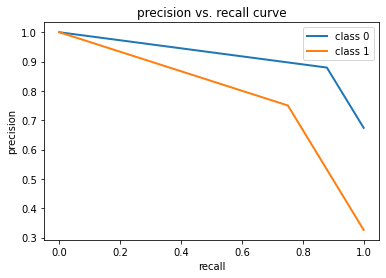

In [ ]:
plot_precision_recall_curve(predictions,y_validation,2)

In [ ]:
p,r,t	=gen_precision_recall(2,y_validation,predictions)

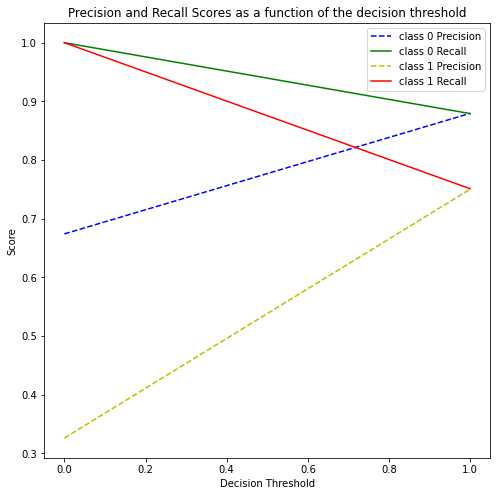

In [ ]:
plot_precision_recall_vs_threshold(p,r,t,2)

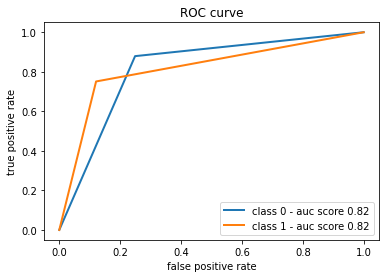

In [ ]:
plot_roc_curve(y_validation,predictions,2)

##### Saving Classifier Model

In [ ]:
history_pkl = open(data_path+'/history','wb')
pickle.dump(history,history_pkl)
history_pkl.close()

In [ ]:
model.save(data_path+'/Pneumonia_Classifier_v5.h5',overwrite=True)

In [ ]:
model.save_weights(data_path+'/Pneumonia_Classifier_weights_v5.h5',overwrite=True)

In [ ]:
'''
model1 = load_model(data_path+'/Pneumonia_Classifier_v5.h5')
history_pkl = open(data_path+'/history','rb')
history_pkl= pickle.load(history_pkl)
'''

### Pneumonia Region Detection Model Training and Validation

Approach:
  - Pneumonia CXR data preparation/gathering for training and validation
  - Split the data and target labels for training and validation
  - Base Layer (Pretrained Resnet50v2 layer) for feature map extraction
  - RPN (Region Proposal Network) with anchors (scale x ratio) to classify objects and bounding boxes
  - Convert RPN to ROI boxes
  - Calculate IOU (Intersection Over Union between Ground truth and ROI boxes)
  - Finding Positive and Negative anchor boxes based on overlap threshold values
  - Classification layer with the input of Input Image, GroundTruth bounding boxes with positive and negative anchor boxes labeling, Classification label for the input image and bounding boxes (x,y,w,h) for the input image
  - Aggregate the training losses from RPN classification, regression and Classifier(detector) classification and regression losses per each epoch
  - Calculate mean_overlapping_bboxes, classification accuracy for RPN bounding boxes,Loss of RPN classifier, Loss of RPN regression, Loss detector classifier and Loss detector regression and total loss 
  - Chart the losses

#### Classes for RoI pooling, Region proposal network and detection

In [ ]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        #self.dim_ordering = K.common.image_dim_ordering()
        #print('Coming Inside RoiPoolingConv Init')
        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois
        #print('self.dim_ordering :{},self.pool_size:{},self.num_rois:{} '.format(self.dim_ordering,self.pool_size,self.num_rois) )
        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        #print('Coming Inside RoiPoolingConv build')
        self.nb_channels = input_shape[0][3] 
        

    def compute_output_shape(self, input_shape):
        #print('Coming Inside RoiPoolingConv compute_output_shape')
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        #print('Coming Inside RoiPoolingConv call')
        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]
        #print('img %s'%(img))
        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]
        #print('rois:{}'.format(rois))
        input_shape = K.shape(img)
        #print('input_shape:{}'.format(input_shape))
        outputs = []

        for roi_idx in range(self.num_rois):
            #print('roi_idx:{}'.format(roi_idx))
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
            #print('x:{},y:{},w:{},h:{}'.format(x,y,w,h))
            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')
            #print('After casting x:{},y:{},w:{},h:{}'.format(x,y,w,h))
            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
            #print('ouputs of {} is {}'.format(roi_idx,outputs))

        final_output = K.concatenate(outputs, axis=0)
        #print('Before reshape final_output:{}'.format(final_output))
        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))
        #print('After reshape final_output:{}'.format(final_output))
        return final_output
    
    
    def get_config(self):
        #print('Coming Inside RoiPoolingConv get_config')
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class objectDetector():
  def __init__(self):
   # Print the process or not
   self.verbose = True
   # Setting for data augmentation
   self.use_horizontal_flips = False
   self.use_vertical_flips = False
   self.rot_90 = False
   # Anchor box scales Note that if im_size is smaller, anchor_box_scales should be scaled
   #self.anchor_box_scales = [116,90, 156,198, 373,326, 30,61, 62,45, 59,119, 10,13, 16,30, 33,23]  # 1
   #self.anchor_box_scales = [128,800, 640,198, 373,512, 30,61, 62,45, 59,119, 10,13, 16,30, 33,23,1024,1115]
   #self.anchor_box_scales = [128,800, 640,198, 373,512, 30,61, 62,45, 59,119, 2000,2500,2,5,10,13, 16,30, 33,23,1024,1350,1600,300,3500]
   #self.anchor_box_scales = [300,400,500,700,900,1200,1500,1800,2200,2600]
   #self.anchor_box_scales = [45,47,50,52,54,55,56,58,60,65]
   self.anchor_box_scales = [38.5,39,39.5,40,40.5,41,41.5,42,42.5,43]
   #self.anchor_box_scales = [116,90, 156,198, 373,326, 523,623, 763,893, 59,623, 1024,1350, 1600,1900, 2300,23]
   #self.anchor_box_scales = [116,90, 156,198, 373,326, 523,623, 763,893, 59,623, 1024,1350, 1600,1900, 2300,3200]
   #self.anchor_box_scales = [116,90, 156,198, 373,326, 523,623, 763,893, 3800,623, 1024,1350, 1600,1900, 2300,3200]
   #self.anchor_box_scales = [59,80,116,90, 156,198, 373,326, 523,623, 763,893, 923,1113, 1024,1350, 1600,1900, 2300,2570,3250,3600,4180]
   #self.anchor_box_scales = [128,256,512]
   #self.anchor_box_scales = [2,4,8,12,20,25,30,60,80,120]
   # Anchor box ratios
   #self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]] # 1
   self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]
   # Size to resize the smallest side of the image
   self.resized_img_rsize = 224
   self.resized_img_csize = 224
   self.org_img_rsize = 1024
   self.org_img_csize = 1024
   self.channel =3
   # number of ROIs at once
   self.num_rois = 2
   self.pool_region = 7
   # stride at the RPN (this depends on the network configuration)
   self.rpn_stride = 52 #36,52 - 1
   # overlaps for RPN
   self.rpn_min_overlap = 0.3
   self.rpn_max_overlap = 0.7
   # overlaps for classifier ROIs
   self.classifier_min_overlap = 0.1
   self.classifier_max_overlap = 0.5
   # image channel-wise mean to subtract
   self.img_channel_mean = [103.939, 116.779, 123.68]
   self.img_scaling_factor = 1.0
   # scaling the stdev
   self.std_scaling = 4.0
   self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]
   self.num_epochs =20
   self.num_features = 224
   self.class_mapping = {'Lung Opacity':1,'background':0} 

  def get_data(self,x):
      """Parse the data
      Args:
        input: Dataframe with bounding box details (x,y,w and h) and image path

      Returns:
        all_data: list(filepath, width, height, list(bboxes))
        classes_count: dict{key:class_name, value:count_num} 
          e.g. {'Lung Opacity': 3000}
        class_mapping: dict{key:class_name, value: idx}
          e.g. {'Lung Opacity': 1}
      """
      visualise = True
      # Convert input dataframe into dict variable
      data_dict = list(x.T.to_dict().values())
      train_data = pd.DataFrame(columns=['patientId','class','x','y','width','height','Target','image_path','bboxes'])
      # Loop all records
      for i, row in enumerate(data_dict):
        train_data.loc[i,'patientId'] = row['patientId']
        train_data.loc[i,'class'] = row['class']
        scale_x = (self.resized_img_rsize*row['x'])/self.org_img_rsize
        scale_y = (self.resized_img_csize*row['y'])/self.org_img_csize
        scale_width = (self.resized_img_rsize*row['width'])/self.org_img_rsize
        scale_height = (self.resized_img_csize *row['height'])/self.org_img_csize
        train_data.loc[i,'x'] = scale_x
        train_data.loc[i,'y'] = scale_y
        train_data.loc[i,'width']= scale_width
        train_data.loc[i,'height']=scale_height
        train_data.loc[i,'Target']=row['Target']
        train_data.loc[i,'image_path']=row['image_path']
        val = {'class': 'Lung Opacity', 'x1': scale_x, 'x2': (scale_x+scale_width), 'y1': scale_y, 'y2': (scale_y+scale_height)}
        train_data.loc[i,'bboxes']= [val]
      train_records_size=round(len(train_data) *(80/100))
      val_records_size=len(train_data)-train_records_size
      train_rec=train_data.iloc[:train_records_size,:]
      val_rec = train_data.iloc[:val_records_size,:]
      # We will forward only Pneumonia patient images to Object Detection model so only one class is there always
      train_classes_count = {'Lung Opacity':len(train_rec),'background':0}
      val_classes_count = {'Lung Opacity':len(val_rec),'background':0}
      class_mapping = {'Lung Opacity':1,'background':0}
      return train_rec,val_rec,train_classes_count,val_classes_count, class_mapping

    
  def augment(self,img_data,augment=True):
      #print('augment')
      assert 'image_path' in img_data
      assert 'x' in img_data
      assert 'y' in img_data
      assert 'width' in img_data
      assert 'height' in img_data
      img_data_aug = img_data.copy()
      data_dict = list(img_data.T.to_dict().values())
      img = np.array(img_to_array(load_img(str(data_dict[0]['image_path']),target_size=(self.resized_img_rsize, self.resized_img_csize))).astype('float32'))/255.0
      #scale_x = (C.resized_img_rsize*img_data_aug['x'])/C.org_img_rsize
      #scale_y = (C.resized_img_csize*img_data_aug['y'])/C.org_img_csize
      #scale_width = (C.resized_img_rsize*img_data_aug['width'])/C.org_img_rsize
      #scale_height = (C.resized_img_csize * img_data_aug['height'])/C.org_img_csize
      #print('{},{},{},{}'.format(scale_y, img_data_aug['y'],scale_height,img_data_aug['height']))
      #img_data_aug['x']=scale_x
      #img_data_aug['y']= scale_y
      #img_data_aug['width']=scale_width
      #img_data_aug['height']=scale_height
      #print(img_data_aug.loc[0,'x'], img_data_aug.loc[0,'y'])
      #print('{},{},{},{}'.format(scale_y, img_data_aug['y'],scale_height,img_data_aug['height']))
      if augment:
        if self.use_horizontal_flips and np.random.randint(0, 2) == 0:
          #print(1)
          img = cv2.flip(img, 1)
          img_data_aug.loc[0,'x']=self.resized_img_csize - (img_data_aug.loc[0,'x']+img_data_aug.loc[0,'width'])
          img_data_aug.loc[0,'y']= img_data_aug.loc[0,'y']
          img_data_aug.loc[0,'width']=img_data_aug.loc[0,'width']
          img_data_aug.loc[0,'height']=img_data_aug.loc[0,'height']
          img_data_aug.loc[0,'bboxes'] = [{'class': 'Lung Opacity', 'x1': img_data_aug.loc[0,'x'], 'x2': (img_data_aug.loc[0,'x']+img_data_aug.loc[0,'width']), 'y1': img_data_aug.loc[0,'y'], 'y2': (img_data_aug.loc[0,'y']+img_data_aug.loc[0,'height'])}]
        elif self.use_vertical_flips and np.random.randint(0, 2) == 0:
          #print(2)
          img = cv2.flip(img, 0)
          img_data_aug.loc[0,'x']=img_data_aug.loc[0,'x']
          img_data_aug.loc[0,'y']= self.resized_img_rsize - (img_data_aug.loc[0,'y']+img_data_aug.loc[0,'height'])
          img_data_aug.loc[0,'width']=img_data_aug.loc[0,'width']
          img_data_aug.loc[0,'height']=img_data_aug.loc[0,'height']
          img_data_aug.loc[0,'bboxes'] = [{'class': 'Lung Opacity', 'x1': img_data_aug.loc[0,'x'], 'x2': (img_data_aug.loc[0,'x']+img_data_aug.loc[0,'width']), 'y1': img_data_aug.loc[0,'y'], 'y2': (img_data_aug.loc[0,'y']+img_data_aug.loc[0,'height'])}]
        elif self.rot_90:
          #print(3)
          img1 = np.transpose(img, (1,0,2))
          img = cv2.flip(img1, 1)
          #print('{}, {}, {}, {}'.format(scale_y, img_data_aug['y'],scale_height,img_data_aug['height']))
          x=img_data_aug.loc[0,'x']
          y=img_data_aug.loc[0,'y']
          width = img_data_aug.loc[0,'width']
          height =img_data_aug.loc[0,'height']
          img_data_aug.loc[0,'x']=self.resized_img_rsize - (y+height)#(scale_y+scale_height)
          img_data_aug.loc[0,'y']= x
          img_data_aug.loc[0,'width']=height
          img_data_aug.loc[0,'height']= width
          #print(img_data_aug.loc[0,'x'], img_data_aug.loc[0,'y'])
          img_data_aug.loc[0,'bboxes'] = [{'class': 'Lung Opacity', 'x1': img_data_aug.loc[0,'x'], 'x2': (img_data_aug.loc[0,'x']+img_data_aug.loc[0,'width']), 'y1': img_data_aug.loc[0,'y'], 'y2': (img_data_aug.loc[0,'y']+img_data_aug.loc[0,'height'])}]
      #fig, ax = plt.subplots(1,1, figsize=(3,3))  
      #ax.imshow(img,cmap = plt.cm.bone) # Original Image
      #rectangle = patches.Rectangle(xy=(img_data_aug.loc[0,'x'], img_data_aug.loc[0,'y']),
                            #width=img_data_aug.loc[0,'width'],height=img_data_aug.loc[0,'height'], 
                            #color="yellow",fc='none',ec='r', lw=4)
      #ax.add_patch(rectangle)
      #plt.show()
      
      return img_data_aug, img


  def bb_intersection_over_union(self,a, b):
        #Compute the area of intersection
        #print('bb_intersection_over_union')
        if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
          return 0.0
        xA = max(a[0], b[0])
        #print('xA=',xA)
        yA = max(a[1], b[1])
        #print('yA=',yA)
        wA = min(a[2],b[2])-xA
        #print('wA=',wA)
        hA = min(a[3],b[3])-yA
        #print('hA=',hA)
        # compute the area of intersection rectangle
        
        if wA < 0 or hA < 0:
          interArea = 0.0
        else:
          interArea = wA*hA
        #interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        # Compute the area of both ground truth and prediction boxes
        a_box_area = (a[2]-a[0]) * (a[3]-a[1])
        b_box_area = (b[2] - b[0]) * (b[3] - b[1])
        iou = float(interArea) / float(a_box_area + b_box_area - interArea)
        #print('IoU: {}'.format(iou))
        return iou
    
  def calc_rpn(self,img_data):
      downscale = float(self.rpn_stride)
      anchor_sizes = self.anchor_box_scales
      anchor_ratios = self.anchor_box_ratios
      num_anchors = len(anchor_sizes) * len(anchor_ratios)
      #print('Coming Inside calc_rpn')
    # calculate the output map size based on the network architecture

      #(output_width, output_height) = (C.resized_img_rsize // 30,C.resized_img_csize // 30) # resizing according to the output shape of RPN layer model summary
      (output_width, output_height) = (5,5)
      n_anchratios = len(anchor_ratios)  # 3

      # initialise empty output objectives

      y_rpn_overlap = np.zeros((int(output_height), int(output_width),
                              num_anchors))
      
      y_is_box_valid = np.zeros((int(output_height), int(output_width),
                                num_anchors))
      y_rpn_regr = np.zeros((int(output_height), int(output_width),
                            num_anchors*4))

      num_bboxes = len(img_data['bboxes']) #1
      #print('num_bboxes=',num_bboxes)
      
      num_anchors_for_bbox = np.zeros(num_bboxes).astype(int) #shape =1
      #print('num_anchors_for_bbox',num_anchors_for_bbox.shape)
      best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int) #shape =1,4
      #print('best_anchor_for_bbox',best_anchor_for_bbox.shape)
      best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32) #shape =1
      #print('best_iou_for_bbox',best_iou_for_bbox.shape)
      best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int) #shape =1,4
      #print('best_x_for_bbox',best_x_for_bbox.shape)
      best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32) #shape =1,4
      #print('best_dx_for_bbox',best_dx_for_bbox.shape)

      # get the GT box coordinates, and resize to account for image resizing

      gta = np.zeros((num_bboxes, 4)) # Ground truth anchor shape 1,4
      for (bbox_num, bbox) in enumerate(img_data['bboxes']):
          gta[bbox_num, 0] = bbox[0]['x1']
          gta[bbox_num, 1] = bbox[0]['y1']
          gta[bbox_num, 2] = bbox[0]['x2']
          gta[bbox_num, 3] = bbox[0]['y2']
          #print(bbox[0]['x1'],bbox[0]['y1'],bbox[0]['x2'],bbox[0]['y2'])

      # rpn ground truth
      #print('anchor_sizes',anchor_sizes) #[128, 256, 512]
      
      for anchor_size_idx in range(len(anchor_sizes)): # Loop 3 times
          for anchor_ratio_idx in range(n_anchratios): # Loop 3 times so totally upper and current for loops will produce 3x3 9 combinations i.e. 9 anchors
              anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
              #print(anchor_sizes[anchor_size_idx],anchor_ratios[anchor_ratio_idx][0])
              anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]
              #print(anchor_sizes[anchor_size_idx],anchor_ratios[anchor_ratio_idx][1])
              for ix in range(int(output_width)):
                  
                  # x-coordinates of the current anchor box....

                  x1_anc = downscale * (ix + 0.5) - anchor_x / 2
                  x2_anc = downscale * (ix + 0.5) + anchor_x / 2

                  # ignore boxes that go across image boundaries....................
                  #print('x1_anc=',x1_anc)
                  #print('x2_anc=',x2_anc)
                  if x1_anc < 0 or x2_anc > self.resized_img_rsize:
                      #print('hi')
                      continue

                  for jy in range(int(output_height)):

                      # y-coordinates of the current anchor box
                      #print('hi')
                      y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                      y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                      # ignore boxes that go across image boundaries

                      if y1_anc < 0 or y2_anc > self.resized_img_csize:
                          #print('hoho')
                          continue

                      # bbox_type indicates whether an anchor should be a target
                      # Initialize with 'negative'
                      #print('yes')
                      bbox_type = 'neg'

                      # this is the best IOU for the (x,y) coord and the current anchor
                      # note that this is different from the best IOU for a GT bbox

                      best_iou_for_loc = 0.0

                      for bbox_num in range(num_bboxes):

                          # get IOU of the current GT box and the current anchor box

                          curr_iou = self.bb_intersection_over_union([gta[bbox_num,
                                  0], gta[bbox_num, 1], gta[bbox_num, 2],
                                  gta[bbox_num, 3]], [x1_anc, y1_anc,
                                  x2_anc, y2_anc])

                          # calculate the regression targets if they will be needed
                          #print(curr_iou,best_iou_for_bbox[bbox_num],C.rpn_max_overlap)
                          if curr_iou > best_iou_for_bbox[bbox_num]  or curr_iou > self.rpn_max_overlap:
                              cx = (gta[bbox_num, 0] + gta[bbox_num, 2])/ 2.0
                              cy = (gta[bbox_num, 1] + gta[bbox_num, 3])/ 2.0
                              cxa = (x1_anc + x2_anc) / 2.0
                              cya = (y1_anc + y2_anc) / 2.0

                              # x,y are the center point of ground-truth bbox
                              # xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
                              # w,h are the width and height of ground-truth bbox
                              # wa,ha are the width and height of anchor bboxe
                              # tx = (x - xa) / wa
                              # ty = (y - ya) / ha
                              # tw = log(w / wa)
                              # th = log(h / ha)

                              tx = (cx - cxa) / (x2_anc - x1_anc)
                              ty = (cy - cya) / (y2_anc - y1_anc)
                              tw = np.log((gta[bbox_num, 2]
                                      - gta[bbox_num, 0]) / (x2_anc
                                      - x1_anc))
                              th = np.log((gta[bbox_num, 3]
                                      - gta[bbox_num, 1]) / (y2_anc
                                      - y1_anc))

                          #if img_data['bboxes'][bbox_num]['class'] != 'background':

                              # all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best

                          if curr_iou > best_iou_for_bbox[bbox_num]:
                              #print('jy,ix,anchor_ratio_idx,anchor_size_idx',jy,ix,anchor_ratio_idx,anchor_size_idx)
                              best_anchor_for_bbox[bbox_num] = [jy, ix,
                                      anchor_ratio_idx, anchor_size_idx]
                              #print('1',best_anchor_for_bbox[bbox_num])
                              best_iou_for_bbox[bbox_num] = curr_iou
                              best_x_for_bbox[bbox_num, :] = [x1_anc,
                                      x2_anc, y1_anc, y2_anc]
                              #print('2',best_x_for_bbox[bbox_num, :])
                              best_dx_for_bbox[bbox_num, :] = [tx, ty,
                                      tw, th]
                              #print('3',best_dx_for_bbox[bbox_num, :])
                              #print('bboxtype')
                              # we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)

                          if curr_iou > self.rpn_max_overlap:
                              bbox_type = 'pos'
                              #print('coming positive')
                              num_anchors_for_bbox[bbox_num] += 1

                                  # we update the regression layer target if this IOU is the best for the current (x,y) and anchor position

                              if curr_iou > best_iou_for_loc:
                                  best_iou_for_loc = curr_iou
                                  #print(4)
                                  best_regr = (tx, ty, tw, th)
                                  #print(5)
                              # if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective

                          if self.rpn_min_overlap < curr_iou < self.rpn_max_overlap:

                                  # gray zone between neg and pos

                              if bbox_type != 'pos':
                                  #print('coming negative')
                                  bbox_type = 'neutral'

                      # turn on or off outputs depending on IOUs
                      
                      if bbox_type == 'neg':
                          y_is_box_valid[jy, ix, anchor_ratio_idx
                                  + n_anchratios * anchor_size_idx] = 1 
                          y_rpn_overlap[jy, ix, anchor_ratio_idx
                                  + n_anchratios * anchor_size_idx] = 0
                          #print(1000)
                      elif bbox_type == 'neutral':
                          y_is_box_valid[jy, ix, anchor_ratio_idx
                                  + n_anchratios * anchor_size_idx] = 0
                          y_rpn_overlap[jy, ix, anchor_ratio_idx
                                  + n_anchratios * anchor_size_idx] = 0
                          #print(2000)
                      elif bbox_type == 'pos':
                          y_is_box_valid[jy, ix, anchor_ratio_idx
                                  + n_anchratios * anchor_size_idx] = 1
                          y_rpn_overlap[jy, ix, anchor_ratio_idx
                                  + n_anchratios * anchor_size_idx] = 1
                          #print(y_rpn_overlap)
                          #start = 4*(anchor_ratio_idx + n_anchratios
                                  #* anchor_size_idx)
                          #y_rpn_regr[jy, ix, start:start + 4] = best_regr
                          #print('Start1 =',start)
                          #print(6)
                          
                          start = 4*(anchor_ratio_idx + n_anchratios
                                  * anchor_size_idx)
                          #print('Start=',start)
                          #print('best_regr=',best_regr)
                          #try:
                            #y_rpn_regr[jy, ix, start:start + 4] = [best_regr]
                          #except:
                            #print('6a')
                            #print(y_rpn_regr)
                            #print(jy,ix,start)
                          y_rpn_regr[jy, ix, start:start + 4] = best_regr
                          #print(7)
                          #print('no problem with best_regr')
      # we ensure that every bbox has at least one positive RPN region
      #print('number of bounding boxes=',num_anchors_for_bbox.shape[0])
      #print('y_rpn_regr=',y_rpn_regr.shape)      
      for idx in range(num_anchors_for_bbox.shape[0]):
          if num_anchors_for_bbox[idx] == 0:

              # no box with an IOU greater than zero ...

              if best_anchor_for_bbox[idx, 0] == -1:
                  continue
              #print(best_anchor_for_bbox[idx, 2],n_anchratios,
                    #best_anchor_for_bbox[idx, 3])
              y_is_box_valid[best_anchor_for_bbox[idx, 0],
                            best_anchor_for_bbox[idx, 1],
                            best_anchor_for_bbox[idx, 2] + n_anchratios
                            * best_anchor_for_bbox[idx, 3]] = 1
              y_rpn_overlap[best_anchor_for_bbox[idx, 0],best_anchor_for_bbox[idx, 1],best_anchor_for_bbox[idx, 2] + 
                            n_anchratios * best_anchor_for_bbox[idx, 3]] = 1
              # removed 4
              #start = 4*(best_anchor_for_bbox[idx, 2] + n_anchratios
                          #* best_anchor_for_bbox[idx, 3])
              #y_rpn_regr[best_anchor_for_bbox[idx, 0],
                        #best_anchor_for_bbox[idx, 1], start:start+4] =  best_dx_for_bbox[idx, :]
              #print('best_anchor_for_bbox[idx, 2]=',best_anchor_for_bbox[idx, 2])
              #print('best_anchor_for_bbox[idx, 3]=',best_anchor_for_bbox[idx, 3])
              #print(best_anchor_for_bbox[idx, 2],n_anchratios,best_anchor_for_bbox[idx, 3])
              start = 4*(best_anchor_for_bbox[idx, 2] + n_anchratios
                          * best_anchor_for_bbox[idx, 3])
              #print(7)
              #print('Inside y_rpn_regr')
              #print('Start',start)
              #print(best_dx_for_bbox[idx])
              #print('best_anchor 0',best_anchor_for_bbox[idx, 0])
              #print('best_anchor 1',best_anchor_for_bbox[idx, 1])
              #try:
                #print(y_rpn_regr.shape)
                #y_rpn_regr[best_anchor_for_bbox[idx, 0],best_anchor_for_bbox[idx, 1], start:start+4] =  [best_dx_for_bbox[idx,:]]
              #except:
                #print(8)
                #print(best_dx_for_bbox[idx,:].shape)
                #print(y_rpn_regr[best_anchor_for_bbox[idx, 0],best_anchor_for_bbox[idx, 1], start:start+4].shape)
                #print(best_anchor_for_bbox[idx, 0],best_anchor_for_bbox[idx, 1], start,start+4)
                #print(y_rpn_regr[best_anchor_for_bbox[idx, 0],best_anchor_for_bbox[idx, 1], start:start+4])
              y_rpn_regr[best_anchor_for_bbox[idx, 0],best_anchor_for_bbox[idx, 1], start:start+4] =  best_dx_for_bbox[idx,:]
                #print(9)           
              #print(10)
              #y_rpn_regr[2,1, 52:52+4] =  [best_dx_for_bbox[idx,:]]            
              
              #print('check',y_rpn_regr[best_anchor_for_bbox[idx, 0],
                        #best_anchor_for_bbox[idx, 1], start:start+4])
              #print('No problem with y_rpn_regr')
      y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
      y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

      #print('y_rpn_overlap=',y_rpn_overlap)


      y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
      y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

      y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
      y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

      #print('Before concat y_rpn_regr=',y_rpn_regr)

      pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1,
                          y_is_box_valid[0, :, :, :] == 1))
      neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0,
                          y_is_box_valid[0, :, :, :] == 1))

      num_pos = len(pos_locs[0])
      #print(num_pos,len(neg_locs[0]))

      # one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
      # regions. We also limit it to 256 regions.

      num_regions = 256

      if len(pos_locs[0]) > num_regions / 2:
          val_locs = random.sample(range(len(pos_locs[0])),
                                  len(pos_locs[0]) - num_regions / 2)
          y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs],
                        pos_locs[2][val_locs]] = 0
          num_pos = num_regions / 2

      if len(neg_locs[0]) + num_pos > num_regions:
          val_locs = random.sample(range(len(neg_locs[0])),
                                  len(neg_locs[0]) - num_pos)
          y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs],
                        neg_locs[2][val_locs]] = 0

      y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
      y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1),
                                  y_rpn_regr], axis=1)
      #y_rpn_regr = np.concatenate([y_rpn_overlap,y_rpn_regr], axis=1)
      
      return (np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos)
    
  def get_anchor_gt(self,img_data, mode='train'):
      #print('get_anchor_gt')
      if mode == 'train':
        img_data_aug, x_img = self.augment(img_data, augment=True)
      else:
        img_data_aug, x_img = self.augment(img_data, augment=False)
      #print('Coming in get_anchor_gt')  
      y_rpn_cls, y_rpn_regr, num_pos = self.calc_rpn(img_data_aug)

      #print('After conc y_rpn_regr=',y_rpn_regr)
      #print('Coming in get_anchor_gt')
      #print('y_rpn_cls.shape',y_rpn_cls.shape)
      #print('y_rpn_regr.shape',y_rpn_regr.shape)
      debug_img = x_img.copy()
      # Zero-center by mean pixel, and preprocess image
      
      x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
      x_img = x_img.astype(np.float32)
      #x_img[:, :, 0] -= C.img_channel_mean[0]
      #x_img[:, :, 1] -= C.img_channel_mean[1]
      #x_img[:, :, 2] -= C.img_channel_mean[2]
      x_img /= self.img_scaling_factor
      x_img = np.transpose(x_img, (2, 0, 1))
      x_img = np.expand_dims(x_img, axis=0)
      y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= self.std_scaling

      x_img = np.transpose(x_img, (0, 2, 3, 1))

      #print('y_rpn_cls.shape',y_rpn_cls.shape)
      #print('y_rpn_regr.shape',y_rpn_regr.shape)
      y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
      y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))
      
      
      return np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos
    
    
  def exploreGenerator(self,train_data):
      index_num=1
      X, Y, image_data, debug_img, debug_num_pos = self.get_anchor_gt(train_data.iloc[:index_num,:],  mode='train')
      print('Image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], self.resized_img_rsize))
      print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], self.rpn_stride))
      print(X.shape)
      print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
      print('Shape of y_rpn_cls {}'.format(Y[0].shape))
      print('Shape of y_rpn_regr {}'.format(Y[1].shape))

      print('Number of positive anchors for this image: %d' % (debug_num_pos))
      for i,row in enumerate(image_data['bboxes']):
        gt_x1 = row[i]['x1']
        gt_x2 = row[i]['x2']
        gt_y1 = row[i]['y1']
        gt_y2 = row[i]['y2']
      if debug_num_pos==0:

          img = debug_img.copy()
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          color = (0, 255, 0)
          cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
          cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
          cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

          plt.grid()
          plt.imshow(img)
          plt.show()
      else:
          cls = Y[0][0]
          pos_cls = np.where(cls==1)
          print('pos_cls ',pos_cls)
          regr = Y[1][0]
          pos_regr = np.where(regr==1)
          print('pos_regr ',pos_regr)
          print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
          print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

          img = debug_img.copy()
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          color = (0, 255, 0)
          #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
          cv2.rectangle(img, (int(gt_x1), int(gt_y1)), (int(gt_x2), int(gt_y2)), color, 2)
          cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

          # Add text
          textLabel = 'gt bbox'
          (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
          textOrg = (int(gt_x1), int(gt_y1+5))
          cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
          cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
          cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

          # Draw positive anchors according to the y_rpn_regr
          for i in range(debug_num_pos):

              color = (100+i*(155/4), 0, 100+i*(155/4))

              idx = pos_regr[2][i*4]/4
              anchor_size = self.anchor_box_scales[int(idx/3)]
              anchor_ratio = self.anchor_box_ratios[2-int((idx+1)%3)]

              center = (pos_regr[1][i*4]*self.rpn_stride, pos_regr[0][i*4]*self.rpn_stride)
              print('Center position of positive anchor: ', center)
              cv2.circle(img, center, 3, color, -1)
              anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
              cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
      #         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

      print('Green bboxes is ground-truth bbox. Others are positive anchors')
      plt.figure(figsize=(8,8))
      plt.grid()
      plt.imshow(img)
      plt.show()


  def base_layer(self,img_input):
        #print('coming inside base_layer')
        if not K.is_keras_tensor(img_input):
          img_input = Input(tensor=img_input, shape=input_shape)
        else:
          img_input = img_input
        base_model = resnet_v2.ResNet50V2(weights= 'imagenet', include_top=False, input_tensor=img_input)
        #base_model = resnet_v2.ResNet50V2(weights= 'imagenet', include_top=False, input_shape=(C.resized_img_rsize,C.resized_img_csize,C.channel))
        x = base_model.output
        #x = Conv2D(1024,(1,1))(x)
        return base_model,x


  def classifier_layer(self,base_layers, input_rois,num_rois,nb_classes):
      #def classifier_layer(out_roi_pool, C,nb_classes):
          #print('coming inside classifier_layer')
          pooling_regions = self.pool_region
          #n_rois = C.num_rois 
          out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

          # Flatten, Dense layers with drop outs
          #out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
          #out = TimeDistributed(Dense(1024, activation='relu', name='fc1'))(out)
          #out = TimeDistributed(Dropout(0.5))(out)
          #out = TimeDistributed(Dense(1024, activation='relu', name='fc2'))(out)
          #out = TimeDistributed(Dropout(0.5))(out)
          #out = TimeDistributed(Dense(1024, activation='relu', name='fc3'))(out)
          #out = TimeDistributed(Dense(512, activation='relu', name='fc4'))(out)

          #out = Flatten(name='flatten')(out_roi_pool)
          #out = Dense(1024, activation='relu', name='fc1')(out)
          #out = Dropout(0.5)(out)
          #out = Dense(1024, activation='relu', name='fc2')(out)
          #out = Dropout(0.5)(out)
          #out = Dense(1024, activation='relu', name='fc3')(out)
          #out = Dense(512, activation='relu', name='fc4')(out)
          # There are two output layer
          # out_class: Sigmoid acivation function for classify the class name of the object: Classes: Lung Opacity, background
          # out_regr: linear activation function for bboxes coordinates regression
          #out_class = TimeDistributed(Dense(nb_classes, activation='sigmoid', kernel_initializer='zero',name='dense_class_{}'.format(nb_classes)))(out)
          #out_regr = TimeDistributed(Dense(8, activation='linear', kernel_initializer='zero',name='dense_regress_{}'.format(nb_classes)))(out)
          #out_class = Dense(nb_classes, activation='sigmoid', kernel_initializer='zero',name='dense_class_{}'.format(nb_classes))(out)
          #out_regr = Dense(8, activation='linear', kernel_initializer='zero',name='dense_regress_{}'.format(nb_classes))(out)
          # Flatten the convlutional layer and connected to 2 FC and 2 dropout
          out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
          out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
          out = TimeDistributed(Dropout(0.5))(out)
          out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
          out = TimeDistributed(Dropout(0.5))(out)

          # There are two output layer
          # out_class: softmax acivation function for classify the class name of the object
          # out_regr: linear activation function for bboxes coordinates regression
          out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
          # note: no regression target for bg class
          out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)
          return [out_class, out_regr]

  def rpn_layer(self,base_layers, num_anchors):
    #print('Coming Inside rpn_layer')
    x = Conv2D(1024, (1, 1), activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', kernel_initializer='normal', name='rpn_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', kernel_initializer='normal', name='rpn_conv3')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='normal', name='rpn_conv4')(x)
    x_class = Conv2D(2*num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(8*num_anchors, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    #x_class = Conv2D(2*num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    #x_regr = Conv2D(2*num_anchors, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_class, x_regr, base_layers]

  def obj_det_build_compile(self,classes_count):
        # define the RPN, built on the base layers
        num_anchors = len(self.anchor_box_scales) * len(self.anchor_box_ratios) # 9
        #img_input = Input(shape=(None,None,C.channel))
        roi_input = Input(shape=(self.num_rois, 4))
        img_input = Input(shape=(self.resized_img_rsize,self.resized_img_csize,self.channel))
        #roi_input = Input(shape=(None, 4))
        base_model,shared_layers = self.base_layer(img_input)
        rpn = self.rpn_layer(shared_layers, num_anchors)
        #roi_out_pool = call_RoiPoolingCov(shared_layers, roi_input,C)
        classifier = self.classifier_layer(shared_layers, roi_input, self.num_rois, nb_classes=len(classes_count))
        #classifier = classifier_layer(roi_out_pool,C, nb_classes=len(classes_count))
        #print('rpn[0]:{},rpn[1]:{}'.format(rpn[0],rpn[1]))
        model_rpn = Model(img_input, rpn[:2])
        #model_rpn = Model(base_model.input, rpn[:2])
        model_classifier = Model([img_input, roi_input], classifier)
        #model_classifier = Model(roi_out_pool, classifier)
        # this is a model that holds both the RPN and the classifier, used to load/save weights for the models
        #model_all = Model([img_input, roi_input], rpn[:2] + classifier)
        #model_all = Model([base_model.input, roi_input], rpn[:2] + classifier)
        optimizer = Adam(lr=1e-5)
        optimizer_classifier = Adam(lr=1e-5)
        #model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
        #model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
        model_rpn.compile(optimizer=optimizer, loss=['binary_crossentropy','mae'],metrics=['accuracy', ['accuracy', 'mse']] )
        model_classifier.compile(optimizer=optimizer_classifier, loss=['categorical_crossentropy','mae'], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
        #model_all.compile(optimizer=optimizer, loss='mae',metrics=['accuracy', ['accuracy', 'mae']])
        return model_rpn,model_classifier#,model_all

  def non_max_suppression_fast(self,boxes, probs, overlap_thresh=0.9, max_boxes=300):
            # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
            # if there are no boxes, return an empty list

            # Process explanation:
            #   Step 1: Sort the probs list
            #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
            #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
            #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
            #print('Coming Inside non_max_suppression_fast')
            if len(boxes) == 0:
                #print('hey')
                return []

            # grab the coordinates of the bounding boxes
            x1 = boxes[:, 0]
            y1 = boxes[:, 1]
            x2 = boxes[:, 2]
            y2 = boxes[:, 3]

            np.testing.assert_array_less(x1, x2)
            np.testing.assert_array_less(y1, y2)

            # if the bounding boxes integers, convert them to floats --
            # this is important since we'll be doing a bunch of divisions
            if boxes.dtype.kind == "i":
                boxes = boxes.astype("float")

            # initialize the list of picked indexes	
            pick = []

            # calculate the areas
            area = (x2 - x1) * (y2 - y1)

            # sort the bounding boxes 
            idxs = np.argsort(probs)

            # keep looping while some indexes still remain in the indexes
            # list
            while len(idxs) > 0:
                # grab the last index in the indexes list and add the
                # index value to the list of picked indexes
                last = len(idxs) - 1
                i = idxs[last]
                pick.append(i)

                # find the intersection

                xx1_int = np.maximum(x1[i], x1[idxs[:last]])
                yy1_int = np.maximum(y1[i], y1[idxs[:last]])
                xx2_int = np.minimum(x2[i], x2[idxs[:last]])
                yy2_int = np.minimum(y2[i], y2[idxs[:last]])

                ww_int = np.maximum(0, xx2_int - xx1_int)
                hh_int = np.maximum(0, yy2_int - yy1_int)

                area_int = ww_int * hh_int

                # find the union
                area_union = area[i] + area[idxs[:last]] - area_int

                # compute the ratio of overlap
                overlap = area_int/(area_union + 1e-6)

                # delete all indexes from the index list that have
                idxs = np.delete(idxs, np.concatenate(([last],
                    np.where(overlap > overlap_thresh)[0])))

                if len(pick) >= max_boxes:
                  #print('check pick=',len(pick))
                  break

            # return only the bounding boxes that were picked using the integer data type
            boxes = boxes[pick].astype("int")
            probs = probs[pick]
            #print('boxes=',boxes)
            return boxes, probs


  def rpn_to_roi(self,rpn_layer, regr_layer, use_regr=True, max_boxes=300,overlap_thresh=0.9):
            """Convert rpn layer to roi bboxes
            Returns:
              result: boxes from non-max-suppression (shape=(300, 4))
                boxes: coordinates for bboxes (on the feature map)
            """
            regr_layer = regr_layer / self.std_scaling
            #print('Coming Inside rpn_to_roi')
            anchor_sizes = self.anchor_box_scales   # (3 in here)
            anchor_ratios = self.anchor_box_ratios  # (3 in here)
            assert rpn_layer.shape[0] == 1

            (rows, cols) = rpn_layer.shape[1:3]
            #print('rpn_roi: rows {}, cols {}'.format(rows,cols))
            curr_layer = 0
            #print('regr_layer=',regr_layer)
            # A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
            # A is the coordinates for 9 anchors for every point in the feature map 
            A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
            #print('A.shape=',A.shape)
            for anchor_size in anchor_sizes:
              for anchor_ratio in anchor_ratios:
                # anchor_x = (128 * 1) / 16 = 8  => width of current anchor
                # anchor_y = (128 * 2) / 16 = 16 => height of current anchor
                #print('curr_layer',curr_layer)
                anchor_x = (anchor_size * anchor_ratio[0])/self.rpn_stride
                anchor_y = (anchor_size * anchor_ratio[1])/self.rpn_stride
                #print('anchor_x={},anchor_y={}'.format(anchor_x,anchor_y))
                
                #anchor_x = (anchor_size * anchor_ratio[0])
                #anchor_y = (anchor_size * anchor_ratio[1])
                # curr_layer: 0~8 (9 anchors)
                # the Kth anchor of all position in the feature map (9th in total)
                regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] 
                #print('Before transpose regr={}, {}'.format(regr.shape,regr))
                regr = np.transpose(regr, (2, 0, 1)) # shape => (Coordinates, BB.height, BB.width)

                # Create Feature map height and width based mesh grid
                # For every point in x, there are all the y points and vice versa
                # Create Coordinate matrices for X and Y
                X, Y = np.meshgrid(np.arange(cols),np.arange(rows))

                # Calculate anchor position and size for each feature map point
                A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
                A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
                A[2, :, :, curr_layer] = anchor_x       # width of current anchor
                A[3, :, :, curr_layer] = anchor_y       # height of current anchor

                # Apply regression to x, y, w and h if there is rpn regression layer
                if use_regr:
                  A[:, :, :, curr_layer] = self.apply_regr_np(A[:, :, :, curr_layer], regr)

                # Avoid width and height exceeding 1
                A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
                A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

                # Convert (x, y , w, h) to (x1, y1, x2, y2)
                # x1, y1 is top left coordinate
                # x2, y2 is bottom right coordinate
                A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
                A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

                # Avoid bboxes drawn outside the feature map
                A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
                A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
                A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
                A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

                curr_layer += 1

            all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
            all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

            x1 = all_boxes[:, 0]
            y1 = all_boxes[:, 1]
            x2 = all_boxes[:, 2]
            y2 = all_boxes[:, 3]

            # Find out the bboxes which is illegal and delete them from bboxes list
            idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

            all_boxes = np.delete(all_boxes, idxs, 0)
            all_probs = np.delete(all_probs, idxs, 0)

            # Apply non_max_suppression
            # Only extract the bboxes. Don't need rpn probs in the later process
            #print('all_boxes',all_boxes)
            result = self.non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]
            #print('result',result)
            return result

  def calc_iou(self,R, img_data,  class_mapping):
              """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

              Args:
                  R: bboxes, probs
              """
              bboxes = img_data['bboxes']
              
              #print('calc_iou - bboxes of Img_data: ',bboxes)

              gta = np.zeros((len(bboxes), 4))
              #print('Coming inside calc_iou')

              for bbox_num, bbox in enumerate(bboxes):
                
                  # gta[bbox_num, 0] = 32/ 16 = int(round(2)) = 2 (x in feature map)
                  #print('bbox_num = {}, bbox = {}'.format(bbox_num,bbox))
                  gta[bbox_num, 0] = int(round(bbox[0]['x1']/self.rpn_stride))
                  gta[bbox_num, 1] = int(round(bbox[0]['y1']/self.rpn_stride))
                  gta[bbox_num, 2] = int(round(bbox[0]['x2']/self.rpn_stride))
                  gta[bbox_num, 3] = int(round(bbox[0]['y2']/self.rpn_stride))

              #print('Ground Truth Anchor Coordinates',gta)
              x_roi = []
              y_class_num = []
              y_class_regr_coords = []
              y_class_regr_label = []
              IoUs = [] # for debugging only
            
              # R.shape[0]: number of bboxes (=300 from non_max_suppression)
              #print('R.shape: {} '.format(R.shape[0]))
              
              no_overlap = 0
              overlap =0
              #print('No of boxes',R.shape[0])
              for ix in range(R.shape[0]): # Loop iteration for each box from an CXR image
                  (x1, y1, x2, y2) = R[ix, :]
                  x1 = int(round(x1))
                  y1 = int(round(y1))
                  x2 = int(round(x2))
                  y2 = int(round(y2))
                  #print(x1,y1,x2,y2)
                  #print('loop: {} predictions: x1:{}, y1:{},x2:{},y2:{}'.format(ix,x1,y1,x2,y2))
                  #print('RPN Predicted Anchor Coordinates',(x1,y1,x2,y2))
                  best_iou = 0.0
                  best_bbox = -1
                  # Iterate through all the ground-truth bboxes to calculate the iou
                  #for bbox_num in range(len(bboxes)):
                  for bbox_num, bbox in enumerate(bboxes):
                      curr_iou = self.bb_intersection_over_union([gta[bbox_num, 0], gta[bbox_num, 1], gta[bbox_num, 2], gta[bbox_num, 3]], [x1, y1, x2, y2])
                      #print('current iou1=',curr_iou)
                      # Find out the corresponding ground-truth bbox_num with larget iou
                      if curr_iou > best_iou:
                          best_iou = curr_iou
                          best_bbox = bbox_num

                  #print('best_iou1=',best_iou)
                  if best_iou < self.classifier_min_overlap:
                          no_overlap+=1
                          continue
                  else:
                      w = x2 - x1
                      h = y2 - y1
                      overlap+=1
                      x_roi.append([x1, y1, w, h])
                      IoUs.append(best_iou)
                      #print('current iou2=',curr_iou)
                      #print('best_iou2=',best_iou)
                      if self.classifier_min_overlap <= best_iou < self.classifier_max_overlap:
                          # hard negative example
                          cls_name = 'background'
                      elif self.classifier_max_overlap <= best_iou:
                          cls_name = bbox[best_bbox]['class']
                          cxg = (gta[best_bbox, 0] + gta[best_bbox, 2]) / 2.0
                          cyg = (gta[best_bbox, 1] + gta[best_bbox, 3]) / 2.0

                          cx = x1 + w / 2.0
                          cy = y1 + h / 2.0

                          tx = (cxg - cx) / float(w)
                          ty = (cyg - cy) / float(h)
                          tw = np.log((gta[best_bbox, 2] - gta[best_bbox, 0]) / float(w))
                          th = np.log((gta[best_bbox, 3] - gta[best_bbox, 1]) / float(h))
                      else:
                          #print('roi = {}'.format(best_iou))
                          raise RuntimeError

                  class_num = class_mapping[cls_name]
                  #print(cls_name,class_num)
                  class_label = len(class_mapping) * [0]
                  class_label[class_num] = 1 # For Lung Opacity = [0,1] ; background = [1,0]
                  #print(class_label)
                  y_class_num.append(copy.deepcopy(class_label))
                  coords = [0]  * 4 * (len(class_mapping) - 1)   ## For two classes (Pneumonia and Background), we create bounding boxes(1,4) for only Pneumonia class
                  labels = [0] * 4 * (len(class_mapping) - 1)
                  if cls_name != 'background':
                      #label_pos = 4 * class_num # class_num =1 for Pneumonia (other than background class) so label_pos =4
                      label_pos =0
                      #print('label_pos=',label_pos)
                      sx, sy, sw, sh = self.classifier_regr_std
                      coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
                      #print('Feature {} Coords {}'.format(overlap,coords))
                      labels[label_pos:4+label_pos] = [1, 1, 1, 1]
                      #print('Feature {} Labels {}'.format(overlap,labels))
                      #y_class_regr_coords.append(copy.deepcopy(np.array(coords)))
                      y_class_regr_coords.append(copy.deepcopy(coords))
                      #print('Pne: coords {}'.format(coords))
                      #print('Pne: y_class_regr_coords {}'.format(y_class_regr_coords))
                      y_class_regr_label.append(copy.deepcopy(labels))
                      #print('Pne: labels {}'.format(labels))
                      #print('Pne: y_class_regr_label {}'.format(y_class_regr_label))
                      #y_class_regr_label.append(copy.deepcopy(np.array(labels)))
                  else:
                      y_class_regr_coords.append(copy.deepcopy(coords))
                      #print('Else Feature {} Coords {}'.format(overlap,coords))
                      y_class_regr_label.append(copy.deepcopy(labels))
                      #print('Else Feature {} Labels {}'.format(overlap,labels))
                  #print('coords=',y_class_regr_coords)
                  #print('labels=', y_class_regr_label)    
              if len(x_roi) == 0:
                  return None, None, None, None

              # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
              X = np.array(x_roi)
              #print('x_roi shape=',X.shape)
              #print('R.shape[0]={},R.shape[1]={}'.format(R.shape[0],R.shape[1]))
              #print('no_overlap=',no_overlap)
              #print('overlap=',overlap)
              # one hot code for bboxes from above => x_roi (X)
              #XX=np.expand_dims(X, axis=0)
              #print('Shape= {}, X={}'.format(XX.shape,np.expand_dims(X, axis=0)))
              Y1 = np.array(y_class_num)
              #YY1=np.expand_dims(Y1, axis=0)
              #print('Shape={}, Y1={}'.format(YY1.shape,np.expand_dims(Y1, axis=0)))
              #y_coords=np.array(y_class_regr_coords)
              #print('y_class_regr_coords {}'.format(y_class_regr_coords))
              #y_label=np.array(y_class_regr_label)
              #print('y_class_regr_label {}'.format(y_class_regr_label))
              #Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=0)
              
              #Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)
              Y2 = np.array(y_class_regr_coords)
              
              #YY2=np.expand_dims(Y2, axis=0)
              #print('Shape={}, Y2={}'.format(YY2.shape,np.expand_dims(Y2, axis=0)))
              
              
              #return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs
              return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs
        
  def obj_det_train(self,train_rec,model_rpn,model_classifier,class_mapping):
          start_time = time.time()
          record_df = pd.DataFrame(columns=['mean_overlapping_bboxes','class_acc','loss_rpn_cls','loss_rpn_regr','loss_class_cls','loss_class_regr','curr_loss','elapsed_time','mAP'])
          rpn_accuracy_rpn_monitor = []
          rpn_accuracy_for_epoch = []
          total_epochs = self.num_epochs
          best_loss = np.Inf
          r_epochs =0
          r_mean_overlapping_bboxes = 0.0
          r_class_acc = 0.0
          r_loss_rpn_cls = 0.0
          r_loss_rpn_regr = 0.0
          r_loss_class_cls = 0.0
          r_loss_class_regr = 0.0
          r_curr_loss = 0.0
          r_elapsed_time = 0.0
          r_mAP = 0.0
          epoch_length = len(train_rec)
          print('epoch_length {},total_epochs {}'.format(epoch_length,total_epochs))
          losses = np.zeros((epoch_length, 5))
          for epoch_num in range(self.num_epochs):
              progbar = generic_utils.Progbar(epoch_length)
              print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))      
              r_epochs += 1
              iter_num = 0
              index_num=0
              while True:
                try:
                  # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
                  #for i in range(len(train_rec)):
                  for i in train_rec.index:  
                    X, Y, img_data, debug_img, debug_num_pos = self.get_anchor_gt(train_rec.loc[i:i,:], mode='train')
                    #index_num+=1;
                    # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]  
                    #print(Y[0].shape,Y[1].shape)    
                    loss_rpn = model_rpn.train_on_batch(X,Y)
                    # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
                    P_rpn = model_rpn.predict_on_batch(X)
                    #print('P_rpn[0].shape[0][1]:{},{}',P_rpn[0].shape[0],P_rpn[0].shape[1])
                    #print('P_rpn[1].shape[0][1]:{},{}',P_rpn[1].shape[0],P_rpn[1].shape[1])
                    #print('=========')
                    #print('rpn_cls',P_rpn[0].shape)
                    #print('rpn_regr',P_rpn[1].shape)
                    #print(2)
                    # R: bboxes (shape=(300,4))
                    # Convert rpn layer to roi bboxes
                    R = self.rpn_to_roi(P_rpn[0], P_rpn[1],use_regr=True, max_boxes=300,overlap_thresh=0.7)
                    #print('Cls shape:{}, Rgr shape:{}'.format(R[0].shape,R[1].shape))
                    #print(3)
                    # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
                    # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
                    # Y1: one hot code for bboxes from above => x_roi (X)
                    # Y2: corresponding labels and corresponding gt bboxes
                    #print('R:{}'.format(R))
                    #print('=======')
                    #print('img_data:{}'.format(img_data))
                    X2, Y1, Y2, IouS = self.calc_iou(R, img_data, class_mapping)
                    #print('X2 {} '.format(X2))
                    #print('Y1 {} '.format(Y1))
                    #print('Y2 {} '.format(Y2))
                    #print('IouS {} '.format(IouS))
                    # If X2 is None means there are no matching bboxes
                    if X2 is None:
                        rpn_accuracy_rpn_monitor.append(0)
                        rpn_accuracy_for_epoch.append(0)
                        if iter_num == epoch_length:
                          iter_num = 0
                          break
                        iter_num += 1
                        continue
                    # Find out the positive anchors and negative anchors
                    neg_samples = np.where(Y1[0, :, -1] == 1)
                    pos_samples = np.where(Y1[0, :, -1] == 0)
                    #print('neg_samples:{}'.format(neg_samples))
                    #print('pos_samples:{}'.format(pos_samples))
                    if len(neg_samples) > 0:
                        neg_samples = neg_samples[0]
                        #print('neg_samples_0:{}'.format(neg_samples))
                    else:
                        neg_samples = []

                    if len(pos_samples) > 0:
                        pos_samples = pos_samples[0]
                        #print('pos_samples_0:{}'.format(pos_samples))
                    else:
                        pos_samples = []

                    rpn_accuracy_rpn_monitor.append(len(pos_samples))
                    rpn_accuracy_for_epoch.append((len(pos_samples)))
                    selected_pos_samples=[]
                    selected_neg_samples=[]
                    if self.num_rois > 1:
                        # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                        if len(pos_samples)>0:
                          if len(pos_samples) < self.num_rois//2:
                            selected_pos_samples = pos_samples.tolist()
                          else:
                            selected_pos_samples = np.random.choice(pos_samples, self.num_rois//2, replace=False).tolist()
                        if len(neg_samples)>0:
                            selected_neg_samples = np.random.choice(neg_samples, self.num_rois - len(selected_pos_samples), replace=False).tolist()
                        else:
                            #print('selected_pos_samples before=',selected_pos_samples)
                            selected_pos_samples = np.random.choice(pos_samples, self.num_rois, replace=True).tolist()
                            #print('selected_pos_samples after=',selected_pos_samples)
                        # Randomly choose (num_rois - num_pos) neg samples
                        #try:
                            #selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                        #except:
                            #selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
                        
                        # Save all the pos and neg samples in sel_samples
                        sel_samples = selected_pos_samples + selected_neg_samples
                        #print('sel_samples:{}'.format(sel_samples))
                    else:
                        # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                        #print('coming inside else')
                        
                        selected_pos_samples = pos_samples.tolist()
                        #print('selected_pos_samples',selected_pos_samples)
                        selected_neg_samples = neg_samples.tolist()
                        #print('selected_neg_samples',selected_neg_samples)
                        #sel_samples = selected_pos_samples + selected_neg_samples
                        #if np.random.randint(0, 2):
                        if len(pos_samples)>0:
                            sel_samples = np.random.choice(pos_samples,self.num_rois).tolist()
                        else:
                            sel_samples = np.random.choice(neg_samples,self.num_rois).tolist()
                            #sel_samples = random.choice(selected_pos_samples)
                            #print('pos_samples',pos_samples)
                            #sel_samples = np.random.choice(pos_samples,C.num_rois).tolist()
                            #print('Positive Samples:{}'.format(sel_samples))

                    # training_data: [X, X2[:, sel_samples, :]]
                    # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
                    #  X                     => img_data resized image
                    #  X2[:, sel_samples, :] => num_rois (1 in here) bboxes which contains selected neg and pos
                    #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
                    #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
                    #print('X2',X2[:, sel_samples])
                    #print('Y1',Y1[:, sel_samples])
                    #print('Y2',Y2[:, sel_samples])
                    """
                    loss_class = model_classifier.train_on_batch(
                        [X, X2[:, sel_samples]], [Y1[:, sel_samples], Y2[:, sel_samples]])
                        
                    """
                    #print('Types X:{}, X2:{},Y1:{},Y2:{}'.format(X.dtype,X2.dtype,Y1.dtype,Y2.dtype))
                    #x = np.array([X,X2[:, sel_samples]]).astype("float32")
                    #y = np.array([Y1[:, sel_samples], Y2[:, sel_samples]]).astype("int64")
                    #loss_class = model_classifier.train_on_batch(x,y)
                    #loss_class = model_classifier.train_on_batch(
                        #[X, X2[:, sel_samples]], [Y1[:, sel_samples], Y2[:, sel_samples]])
                    #X=np.asarray(X).astype(np.float32)
                    #X2= np.asarray(X2).astype(np.float32)
                    #Y1=np.asarray(Y1).astype(np.float32)
                    #Y2=np.asarray(Y2).astype(np.object)
                    #tf.convert_to_tensor()

                    #loss_class = model_classifier.train_on_batch(
                        #[FloatTensor(X), FloatTensor(X2[:, sel_samples])], [(Y1[:, sel_samples].astype(np.float64)), [Y2[:, sel_samples]]])
                    #print('sel_samples',sel_samples)
                    # reconstruct Y2 with all inner elements as int objects
                    #Y2_sel =[]
                    #print(Y2)
                    #Y2 = list(map(int, Y2)) 
                    #for i,row  in enumerate(sel_samples):
                        #print(Y2[row])
                        #Y2_sel.append(Y2[row])

                    X = np.array(X)
                    #print('Shape of X = {}'.format(X.shape))
                    #X =np.transpose(X,(1,0,2))
                    #print('sel samples=',sel_samples)
                    X2_sel = np.array(X2[:, sel_samples,:])
                    #X2_sel =np.transpose(X2_sel,(1,0,2))
                    #print('Shape of X2_sel = {}'.format(X2_sel.shape))
                    Y1_sel = np.array(Y1[:, sel_samples,:])
                    #Y1_sel =np.transpose(Y1_sel,(1,0,2))
                    #print('Shape of Y1_sel = {}'.format(Y1_sel.shape))
                    #print('sel_samples=',sel_samples)
                    Y2_sel= np.array(Y2[:,sel_samples,:])
                    #print('Y2_sel=',Y2_sel)
                    #Y2_sel =np.transpose(Y2_sel,(1,0,2))
                    #print('Shape of Y2_sel = {}'.format(Y2_sel.shape))
                    #print('Y1=',Y1)
                    #print('Y2=',Y2)
                    #print('Y1_sel=',Y1_sel)
                    #print('Y2_sel=',Y2_sel)
                    #loss_class = model_classifier.train_on_batch(
                        #[X, X2[:, sel_samples]], [Y1[:, sel_samples], Y2[:, sel_samples]])
                    #print('Y1_sel=',Y1_sel)
                    #print('Y2_sel=',Y2_sel)
                    #print('X2_sel',X2_sel)
                    #roi_out_pool = call_RoiPoolingCov(X, X2_sel,C)
                    #print(roi_out_pool)
                    #loss_class = model_classifier.train_on_batch(
                        #[X, X2_sel], [Y1_sel, Y2_sel])
                    loss_class = model_classifier.train_on_batch([X, X2_sel],[Y1_sel, Y2_sel])
                    #p_class,p_regr = model_classifier.predict_on_batch(
                        #[X, X2_sel])
                    #print('p_class=',p_class)
                    #print('p_regr=',p_regr)
                    #print(6)
                    losses[iter_num, 0] = loss_rpn[1]
                    #print('loss_rpn[1]=',loss_rpn[1])
                    losses[iter_num, 1] = loss_rpn[2]
                    #print('loss_rpn[2]=',loss_rpn[2])

                    losses[iter_num, 2] = loss_class[1]
                    #print('loss_class[1]=',loss_class[1])
                    losses[iter_num, 3] = loss_class[2]
                    #print('loss_class[2]=',loss_class[2])
                    losses[iter_num, 4] = loss_class[3]
                    #print('loss_class[3]=',loss_class[3])

                    iter_num += 1
                    #print('iter_num=',iter_num)
                    #print('np.mean(losses[:iter_num, 0]',np.mean(losses[:iter_num, 0]))
                    
                    progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                              ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
                    #print(7)
                    if iter_num == epoch_length:
                        #print('last iteration of the current epoch')
                        loss_rpn_cls = np.mean(losses[:, 0])
                        #print('loss_rpn_cls',loss_rpn_cls)
                        loss_rpn_regr = np.mean(losses[:, 1])
                        #print('loss_rpn_regr',loss_rpn_regr)
                        loss_class_cls = np.mean(losses[:, 2])
                        #print('loss_class_cls',loss_class_cls)
                        loss_class_regr = np.mean(losses[:, 3])
                        #print('loss_class_regr',loss_class_regr)
                        class_acc = np.mean(losses[:, 4])
                        #print('class_acc',class_acc)
                        mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch) / len(rpn_accuracy_for_epoch))
                        if mean_overlapping_bboxes == 0.0:
                            print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
                        rpn_accuracy_for_epoch = []

                        if self.verbose:
                            print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                            print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                            print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                            print('Loss RPN regression: {}'.format(loss_rpn_regr))
                            print('Loss Detector classifier: {}'.format(loss_class_cls))
                            print('Loss Detector regression: {}'.format(loss_class_regr))
                            print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                            print('Elapsed time: {}'.format(time.time() - start_time))
                            elapsed_time = (time.time()-start_time)/60
                            

                        curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                        #print('curr_loss',curr_loss)
                        #print('best_loss',best_loss)
                        iter_num = 0
                        start_time = time.time()

                        if curr_loss < best_loss:
                            
                            if self.verbose:
                                print('Total loss decreased from {} to {}'.format(best_loss,curr_loss))
                            best_loss = curr_loss
                            best_model_rpn = model_rpn
                            best_model_classifier = model_classifier                    
                            #model_rpn.save('./Pneumonia_Detector_rpn_v6.h5',overwrite=True)
                            #model_rpn.save_weights('./Pneumonia_Detector_rpn_weights_v6.h5',overwrite=True)
                            #model_classifier.save('./Pneumonia_Detector_classifier_v6.h5',overwrite=True)
                            #model_classifier.save_weights('./Pneumonia_Detector_classifier_weights_v6.h5',overwrite=True)
                            #model_all.save('./Pneumonia_Detector_v5.h5',overwrite=True)
                            #model_all.save_weights('./Pneumonia_Detector_weights_v5.h5',overwrite=True)
                          
                        if r_epochs == self.num_epochs:
                          print('Saving the best model')
                          best_model_rpn.save(data_path+'/Pneumonia_Detector_rpn_v6.h5',overwrite=True)
                          best_model_classifier.save(data_path+'/Pneumonia_Detector_classifier_v6.h5',overwrite=True)
                        
                        new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                                  'class_acc':round(class_acc, 3), 
                                  'loss_rpn_cls':round(loss_rpn_cls, 3), 
                                  'loss_rpn_regr':round(loss_rpn_regr, 3), 
                                  'loss_class_cls':round(loss_class_cls, 3), 
                                  'loss_class_regr':round(loss_class_regr, 3), 
                                  'curr_loss':round(curr_loss, 3), 
                                  'elapsed_time':round(elapsed_time, 3), 
                                  'mAP': 0}

                        record_df = record_df.append(new_row, ignore_index=True)
                        iter_num=epoch_length
                        break
                  if iter_num==epoch_length:
                    if X2 is None:
                      loss_rpn_cls = np.mean(losses[:, 0])
                      #print('loss_rpn_cls',loss_rpn_cls)
                      loss_rpn_regr = np.mean(losses[:, 1])
                      #print('loss_rpn_regr',loss_rpn_regr)
                      loss_class_cls = np.mean(losses[:, 2])
                      #print('loss_class_cls',loss_class_cls)
                      loss_class_regr = np.mean(losses[:, 3])
                      #print('loss_class_regr',loss_class_regr)
                      class_acc = np.mean(losses[:, 4])
                      #print('class_acc',class_acc)
                      mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch) / len(rpn_accuracy_for_epoch))
                      if mean_overlapping_bboxes == 0.0:
                          print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
                      rpn_accuracy_for_epoch = []

                      if self.verbose:
                          print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                          print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                          print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                          print('Loss RPN regression: {}'.format(loss_rpn_regr))
                          print('Loss Detector classifier: {}'.format(loss_class_cls))
                          print('Loss Detector regression: {}'.format(loss_class_regr))
                          print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                          print('Elapsed time: {}'.format(time.time() - start_time))
                          elapsed_time = (time.time()-start_time)/60
                          

                      curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                      #print('curr_loss',curr_loss)
                      #print('best_loss',best_loss)
                      iter_num = 0
                      start_time = time.time()

                      if curr_loss < best_loss:
                          
                          if self.verbose:
                              print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                          best_loss = curr_loss
                          best_model_rpn = model_rpn
                          best_model_classifier = model_classifier
                          #model_rpn.save('./Pneumonia_Detector_rpn_v6.h5',overwrite=True)
                          #model_rpn.save_weights('./Pneumonia_Detector_rpn_weights_v6.h5',overwrite=True)
                          #model_classifier.save('./Pneumonia_Detector_classifier_v5.h6',overwrite=True)
                          #model_classifier.save_weights('./Pneumonia_Detector_classifier_weights_v6.h5',overwrite=True)
                          #model_all.save('./Pneumonia_Detector_v5.h5',overwrite=True)
                          #model_all.save_weights('./Pneumonia_Detector_weights_v5.h5',overwrite=True)
                        
                      if r_epochs == self.num_epochs:
                        print('Saving the best model')
                        best_model_rpn.save(data_path+'/Pneumonia_Detector_rpn_v6.h5',overwrite=True)
                        best_model_classifier.save(data_path+'/Pneumonia_Detector_classifier_v6.h5',overwrite=True)
                      
                      new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                                'class_acc':round(class_acc, 3), 
                                'loss_rpn_cls':round(loss_rpn_cls, 3), 
                                'loss_rpn_regr':round(loss_rpn_regr, 3), 
                                'loss_class_cls':round(loss_class_cls, 3), 
                                'loss_class_regr':round(loss_class_regr, 3), 
                                'curr_loss':round(curr_loss, 3), 
                                'elapsed_time':round(elapsed_time, 3), 
                                'mAP': 0}

                      record_df = record_df.append(new_row, ignore_index=True)
                    iter_num=0
                    break     
                except Exception as e:
                  print('Exception: {}'.format(e))
                  continue
          print('Training complete, exiting.')
          return record_df,best_model_rpn,best_model_classifier

  def obj_det_val(self,val_rec,val_classes_count,class_mapping,model_rpn,model_classifier):
            #model_rpn,model_classifier,model_all=obj_det_build_compile(C,val_classes_count)
            #model_rpn.load_weights('./Pneumonia_Detector_rpn_weights_v5.h5')
            #model_classifier.load_weights('./Pneumonia_Detector_classifier_weights_v5.h5')
            start_time = time.time()
            record_df = pd.DataFrame(columns=['patientId','img_path','mean_overlapping_bboxes','class_acc','loss_rpn_cls','loss_rpn_regr','loss_class_cls','loss_class_regr','curr_loss','elapsed_time','mAP','bboxes'])
            rpn_accuracy_rpn_monitor = []
            rpn_accuracy_for_epoch = []
            total_epochs = 1
            best_loss = np.Inf
            r_epochs =0
            r_mean_overlapping_bboxes = 0.0
            r_class_acc = 0.0
            r_loss_rpn_cls = 0.0
            r_loss_rpn_regr = 0.0
            r_loss_class_cls = 0.0
            r_loss_class_regr = 0.0
            r_curr_loss = 0.0
            r_elapsed_time = 0.0
            r_mAP = 0.0
            epoch_length = len(val_rec)
            #print('epoch_length {}'.format(epoch_length))
            losses = np.zeros((epoch_length, 5))
            for epoch_num in range(total_epochs):
              progbar = generic_utils.Progbar(epoch_length)
              print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))      
              r_epochs += 1
              iter_num = 0
              index_num=0
              while True:
                try:
                  # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
                  for i in val_rec.index:
                    #print('length of val records=',len(val_rec))  
                    X, Y, img_data, debug_img, debug_num_pos = self.get_anchor_gt(val_rec.loc[i:i,:], mode='validation')   
                    #print('get_anchor is over')
                    loss_rpn = model_rpn.test_on_batch(X,Y)
                    #print('model rpn test is over')
                    P_rpn = model_rpn.predict_on_batch(X) # Region proposals over the feature maps and positive & negative anchors over them
                    #print('model rpn prediction is over')
                    R = self.rpn_to_roi(P_rpn[0], P_rpn[1], use_regr=True, max_boxes=300,overlap_thresh=0.7) # Convert RPN layers to bounding boxes
                    #print('###ROI Proposals####')
                    #print(img_data.loc[i:i,'image_path'])
                    #paint_ROI(R,img_data.loc[i:i,'image_path'],C)
                    X2, Y1, Y2, IouS = self.calc_iou(R, img_data,  class_mapping) # IOU calculation between proposed bounding boxes and ground truth boxes
                    #print('### After IOU calc ###')
                    #print('X2=',X2)
                    if X2 is None:
                        rpn_accuracy_rpn_monitor.append(0)
                        rpn_accuracy_for_epoch.append(0)
                        if iter_num == epoch_length:
                          iter_num = 0
                          break
                        iter_num += 1
                        continue
                    # Find out the positive anchors and negative anchors
                    neg_samples = np.where(Y1[0, :, -1] == 1)
                    pos_samples = np.where(Y1[0, :, -1] == 0)
                    if len(neg_samples) > 0:
                        neg_samples = neg_samples[0]
                    else:
                        neg_samples = []

                    if len(pos_samples) > 0:
                        pos_samples = pos_samples[0]
                    else:
                        pos_samples = []

                    rpn_accuracy_rpn_monitor.append(len(pos_samples))
                    rpn_accuracy_for_epoch.append((len(pos_samples)))
                    selected_pos_samples=[]
                    selected_neg_samples=[]
                    if self.num_rois > 1:
                        # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                        if len(pos_samples)>0:
                          if len(pos_samples) < self.num_rois//2:
                            selected_pos_samples = pos_samples.tolist()
                          else:
                            selected_pos_samples = np.random.choice(pos_samples, self.num_rois//2, replace=False).tolist()
                        if len(neg_samples)>0:
                            selected_neg_samples = np.random.choice(neg_samples, self.num_rois - len(selected_pos_samples), replace=False).tolist()
                        else:
                            selected_pos_samples = np.random.choice(pos_samples, self.num_rois, replace=True).tolist()
                        sel_samples = selected_pos_samples + selected_neg_samples
                    else:
                        selected_pos_samples = pos_samples.tolist()
                        selected_neg_samples = neg_samples.tolist()
                        #print('Length of positive samples=',len(pos_samples))
                        if len(pos_samples)>0:
                            sel_samples = np.random.choice(pos_samples,self.num_rois).tolist()
                        else:
                            sel_samples = np.random.choice(neg_samples,self.num_rois).tolist()
                            
                    X = np.array(X)
                    X2_sel = np.array(X2[:, sel_samples,:])
                    #print('X2_sel=',X2_sel)
                    #paint_ROI_Sel(X2_sel,img_data.loc[i:i,'image_path'],C)
                    #print('Y1=',np.array(Y1))
                    #print('Y2=',np.array(Y2))
                    Y1_sel = np.array(Y1[:, sel_samples,:])
                    Y2_sel= np.array(Y2[:,sel_samples,:])
                    #print('Y1_sel =',Y1_sel)
                    #print('Y2_sel =',Y2_sel)
                    loss_class = model_classifier.test_on_batch([X, X2_sel],[Y1_sel,Y2_sel])
                    [P_cls, P_regr] = model_classifier.predict_on_batch([X, X2_sel])
                    #print('X2_sel.shape={}, P_cls.shape={},P_regr.shape={}'.format(X2_sel.shape,P_cls.shape,P_regr.shape))
                    #print(X2_sel)
                    #loss_class = model_classifier.evaluate()
                    losses[iter_num, 0] = loss_rpn[1]
                    losses[iter_num, 1] = loss_rpn[2]
                    losses[iter_num, 2] = loss_class[1]
                    losses[iter_num, 3] = loss_class[2]
                    losses[iter_num, 4] = loss_class[3]

                    iter_num += 1
                    
                    progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                              ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
                    
                    loss_rpn_cls = np.mean(losses[:, 0])
                    loss_rpn_regr = np.mean(losses[:, 1])
                    loss_class_cls = np.mean(losses[:, 2])
                    loss_class_regr = np.mean(losses[:, 3])
                    class_acc = np.mean(losses[:, 4])
                    mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch) / len(rpn_accuracy_for_epoch))
                    if mean_overlapping_bboxes == 0.0:
                        print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
                    rpn_accuracy_for_epoch = []

                    if self.verbose:
                        print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                        print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                        print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                        print('Loss RPN regression: {}'.format(loss_rpn_regr))
                        print('Loss Detector classifier: {}'.format(loss_class_cls))
                        print('Loss Detector regression: {}'.format(loss_class_regr))
                        print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                        print('Elapsed time: {}'.format(time.time() - start_time))
                        elapsed_time = (time.time()-start_time)/60

                    curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                    start_time = time.time()
                    bboxes = {}
                    
                    for ii in range(P_cls.shape[1]):
                      if np.argmax(P_cls[0, ii, :]) == 0:
                        cls_name ='background'
                      else:
                        cls_name ='Lung Opacity'
                      (x, y, w, h) = X2_sel[0, ii, :]
                      #print (cls_name)
                      if cls_name=='Lung Opacity':
                        cls_num = np.argmax(P_cls[0, ii, :])
                        
                        try:
                            (tx, ty, tw, th) = P_regr[0, ii, :]
                            
                            tx /= self.classifier_regr_std[0]
                            ty /= self.classifier_regr_std[1]
                            tw /= self.classifier_regr_std[2]
                            th /= self.classifier_regr_std[3]
                            x, y, w, h = self.apply_regr(x, y, w, h, tx, ty, tw, th)
                            
                        except:
                            pass
                        
                      else:
                          cls_num = np.argmax(P_cls[0, ii, :])
                        
                          try:
                              (tx, ty, tw, th) = P_regr[0, ii, :]
                              
                              tx /= self.classifier_regr_std[0]
                              ty /= self.classifier_regr_std[1]
                              tw /= self.classifier_regr_std[2]
                              th /= self.classifier_regr_std[3]
                              x, y, w, h = self.apply_regr(x, y, w, h, tx, ty, tw, th)
                              
                          except:
                              pass
                      if cls_name not in bboxes:
                        bboxes[cls_name] = []
                        
                      bboxes[cls_name].append([self.rpn_stride*x, self.rpn_stride*y, self.rpn_stride*(x+w), self.rpn_stride*(y+h)])
                      #print(x,y,w,h)
                      #print('bboxes=',bboxes)
                    new_row = {'patientId': val_rec.iloc[i]['patientId'] ,
                              'img_path': val_rec.iloc[i]['image_path'],
                                'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                                  'class_acc':round(class_acc, 3), 
                                  'loss_rpn_cls':round(loss_rpn_cls, 3), 
                                  'loss_rpn_regr':round(loss_rpn_regr, 3), 
                                  'loss_class_cls':round(loss_class_cls, 3), 
                                  'loss_class_regr':round(loss_class_regr, 3), 
                                  'curr_loss':round(curr_loss, 3), 
                                  'elapsed_time':round(elapsed_time, 3), 
                                  'mAP': 0,
                                'bboxes':bboxes}

                    record_df = record_df.append(new_row, ignore_index=True)
                    if iter_num == epoch_length:
                      break
                  if iter_num == epoch_length:
                    iter_num=0
                    break

                except Exception as e:
                  print('Exception: {}'.format(e))
                  continue
            print('Validation complete, exiting.')
            return record_df

  def format_img_channels(self,img):
      """ formats the image channels based on config """
      x_img = img[:, :, (2, 1, 0)]
      x_img = x_img.astype(np.float32)
      #x_img[:, :, 0] -= C.img_channel_mean[0]
      #x_img[:, :, 1] -= C.img_channel_mean[1]
      #x_img[:, :, 2] -= C.img_channel_mean[2]
      x_img /= self.img_scaling_factor
      x_img = np.transpose(x_img, (2, 0, 1))
      x_img = np.expand_dims(x_img, axis=0)
      return x_img    
  
  def apply_regr_np(self,X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        #print('Coming Inside apply_regr_np')
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
  def test_run_model(self,img_data,model_rpn,model_classifier):
              #model_rpn,model_classifier=test_model_build(C)
              #model_rpn,model_classifier=test_model_build(C)
              #model_rpn.load_weights('./Pneumonia_Detector_rpn_weights_v5.h5')
              #model_classifier.load_weights('./Pneumonia_Detector_classifier_weights_v5.h5')
              #model_rpn=load_model('./Pneumonia_Detector_rpn_v6.h5')
              #model_classifier=load_model('./Pneumonia_Detector_classifier_v6.h5',custom_objects={'RoiPoolingConv': RoiPoolingConv})
              start_time = time.time()
              record_df = pd.DataFrame(columns=['patientId','img_path','bboxes','elapsed_time'])
              bbox_threshold = self.rpn_max_overlap
              data_dict = list(img_data.T.to_dict().values())
              epoch_length = len(img_data)
              progbar = generic_utils.Progbar(epoch_length)
              iter_num=0
              for idx, row in enumerate(data_dict):
                iter_num += 1      
                progbar.update(iter_num)
                img = np.array(img_to_array(load_img(str(row['img_path']),target_size=(self.resized_img_rsize, self.resized_img_csize))).astype('float32'))/255.0
                X = self.format_img_channels(img)    
                X = np.transpose(X, (0, 2, 3, 1))

                # get output layer Y1, Y2 from the RPN and the feature maps F
                # Y1: y_rpn_cls
                # Y2: y_rpn_regr
                [Y1, Y2] = model_rpn.predict(X)

                # Get bboxes by applying NMS 
                # R.shape = (300, 4)
                R = self.rpn_to_roi(Y1, Y2,overlap_thresh=0.7)
                #paint_ROI(R,img_data.loc[:,'image_path'],C)
                #print(R.shape)
                # convert from (x1,y1,x2,y2) to (x,y,w,h)
                R[:, 2] -= R[:, 0]
                R[:, 3] -= R[:, 1]
                R1=np.expand_dims(R,axis=0)
                #print(R1.shape)
                # apply the spatial pyramid pooling to the proposed regions
                bboxes = {}
                probs = {}
                #print('R=',R)
                #print('R.shape=',R.shape)
                for jk in range(R.shape[0]//self.num_rois + 1):
                    ROIs = np.expand_dims(R[self.num_rois*jk:self.num_rois*(jk+1), :], axis=0)
                    if ROIs.shape[1] == 0:
                        break

                    if jk == R.shape[0]//self.num_rois:
                        #pad R
                        curr_shape = ROIs.shape
                        target_shape = (curr_shape[0],self.num_rois,curr_shape[2])
                        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
                        ROIs_padded[:, :curr_shape[1], :] = ROIs
                        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
                        ROIs = ROIs_padded
                    #paint_ROI_Sel(R1,img_data.loc[:,'image_path'],C)
                    #print(ROIs.shape)
                    [P_cls, P_regr] = model_classifier.predict([X, ROIs])
                    #print('P_cls=',P_cls.shape)
                    #print('P_cls value=', P_cls)
                    #print('P_cls[0, 0, :]=',P_cls[0, 0, :])
                    #print('P_cls[0, 1, :]=',P_cls[0, 1, :])
                    #print('P_regr=',P_regr)
                    #print('P_cls.shape[0]=',P_cls.shape[0])
                    #print('P_cls.shape[1]=',P_cls.shape[1])
                    #print('P_cls.shape[2]=',P_cls.shape[2])
                    # Calculate bboxes coordinates on resized image
                    for ii in range(P_cls.shape[1]):
                        # Ignore 'bg' class
                        #print('np.max(P_cls[0, ii, :])=',np.max(P_cls[0, ii, :]))
                        #print('np.argmax(P_cls[0, ii, :])=',np.argmax(P_cls[0, ii, :]))
                        #print('P_cls.shape[2] - 1=',P_cls.shape[2] - 1)
                        if np.max(P_cls[0, ii, :]) < bbox_threshold: #or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                            #print('background')
                            continue

                        if np.argmax(P_cls[0, ii, :]) == 0:
                          cls_name ='background'
                        else:
                          cls_name ='Lung Opacity'
                      
                        #cls_name = C.class_mapping[0][np.argmax(P_cls[0, ii, :])]

                        if cls_name =='Lung Opacity' and cls_name not in bboxes:
                            bboxes[cls_name] = []
                            probs[cls_name] = []
                        (x, y, w, h) = ROIs[0, ii, :]

                        if cls_name=='Lung Opacity':
                          #print('coming')
                          cls_num = np.argmax(P_cls[0, ii, :])
                          try:
                              (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                              tx /= self.classifier_regr_std[0]
                              ty /= self.classifier_regr_std[1]
                              tw /= self.classifier_regr_std[2]
                              th /= self.classifier_regr_std[3]
                              x, y, w, h = self.apply_regr(x, y, w, h, tx, ty, tw, th)
                          except:
                              pass
                          bboxes[cls_name].append([self.rpn_stride*x, self.rpn_stride*y, self.rpn_stride*(x+w), self.rpn_stride*(y+h)])
                          probs[cls_name].append(np.max(P_cls[0, ii, :]))
                          elapsed_time = (time.time()-start_time)/60
                        
                for key in bboxes:
                    bbox = np.array(bboxes[key])
                    try:
                      new_boxes, new_probs = self.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
                    except:
                      continue
                    new_row = {'patientId': row['patientId'] ,
                              'img_path': row['img_path'],
                              'elapsed_time':round(elapsed_time, 3), 
                              'bboxes':bboxes}

                    record_df = record_df.append(new_row, ignore_index=True)

              return record_df

#### Prepare Data for Object Detection Model

In [ ]:
X1_jpg_image_folder =data_path+'/X1_JPG/'

In [ ]:
X1['image_path']= X1.apply( lambda x: (X1_jpg_image_folder + x["patientId"] + ".jpg" ), axis=1)
X = pd.DataFrame( columns=X1.columns)
X= X.append(X1[X1['Target']==1])

In [ ]:
X = open(data_path+'/X_batch','rb')
X= pickle.load(X)
X= X[X['Target']==1].copy()

In [ ]:
X.shape

(5000, 15)

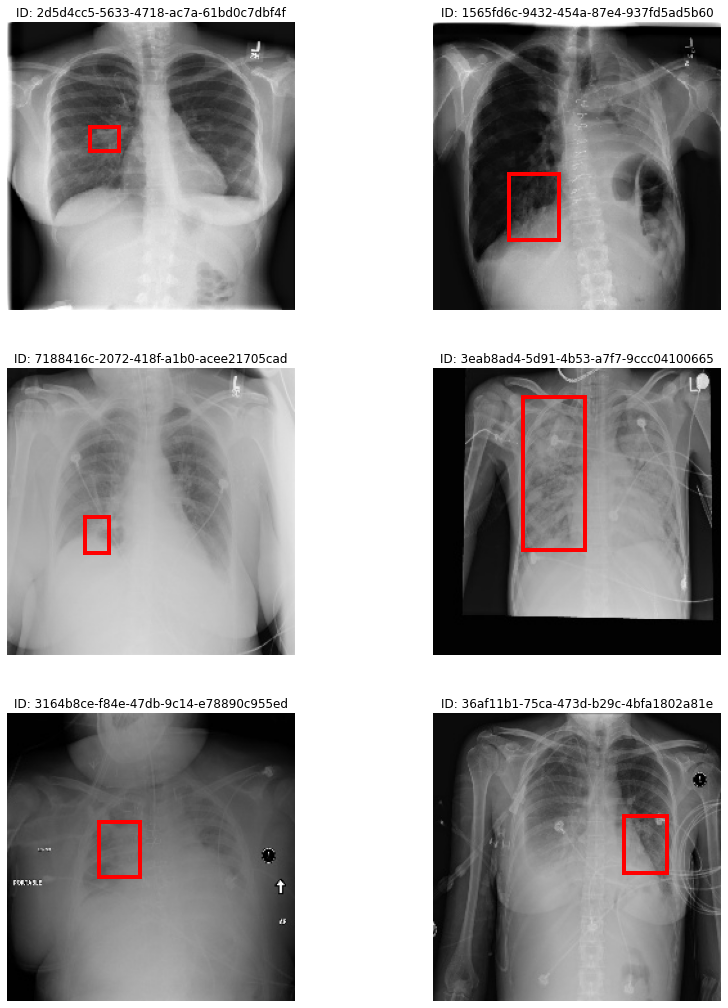

In [ ]:
A = X.sample(6)
show_pneumonia_boxes(A)

In [ ]:
objectDetector = objectDetector()
train_data, validation_data, train_classes_count, val_classes_count,class_mapping = objectDetector.get_data(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: DataFrame columns are not unique, some columns will be omitted.


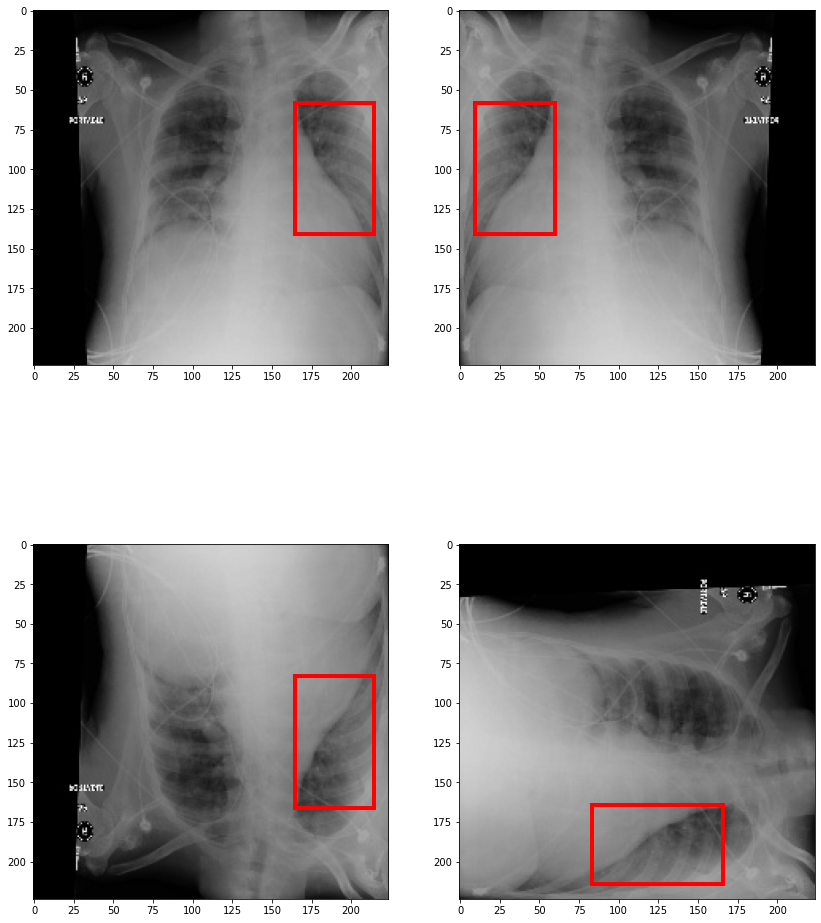

In [ ]:
s=train_data.iloc[0]
plot_aug_img_bbox(s,224,224,1024,1024)

Image:  height=224 width=224 C.im_size=224
Feature map size: height=5 width=5 C.rpn_stride=52
(1, 224, 224, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 5, 5, 60)
Shape of y_rpn_regr (1, 5, 5, 240)
Number of positive anchors for this image: 1
pos_cls  (array([0, 1, 1]), array([3, 3, 3]), array([ 8, 28, 58]))
pos_regr  (array([1, 1, 1, 1]), array([3, 3, 3, 3]), array([112, 113, 114, 115]))
y_rpn_cls for possible pos anchor: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_rpn_regr for positive anchor: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.       

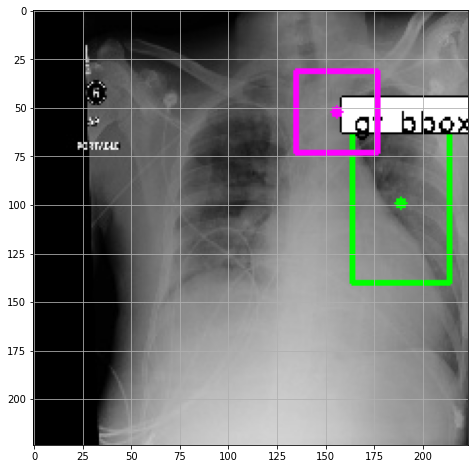

In [ ]:
objectDetector.exploreGenerator(train_data)

#### Region Detection Model

In [ ]:
objectDetector = objectDetector()

In [ ]:
model_rpn,model_classifier=objectDetector.obj_det_build_compile(train_classes_count)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_rpn.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model_classifier.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
train_rec_df,best_model_rpn,best_model_classifier=objectDetector.obj_det_train(train_data,model_rpn,model_classifier,class_mapping)

epoch_length 800,total_epochs 20
Epoch 1/20
800/800 [==============================] - 182s 212ms/step - rpn_cls: 0.4744 - rpn_regr: 0.0015 - final_cls: 0.5629 - final_regr: 0.6301
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.34
Classifier accuracy for bounding boxes from RPN: 0.58875
Loss RPN classifier: 0.32040755908936264
Loss RPN regression: 0.0015225354891299503
Loss Detector classifier: 0.5682309958059341
Loss Detector regression: 0.6249927268654574
Total loss: 1.515153817249884
Elapsed time: 182.1685574054718
Total loss decreased from inf to 1.515153817249884
Epoch 2/20
800/800 [==============================] - 160s 200ms/step - rpn_cls: 0.0491 - rpn_regr: 0.0016 - final_cls: 0.4947 - final_regr: 0.6380
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.34
Classifier accuracy for bounding boxes from RPN: 0.648125
Loss RPN classifier: 0.03437198709696531
Loss RPN regression: 0.0016537728811090347
Loss Detector classifier: 0.49538

In [ ]:
best_model_rpn=load_model(data_path+'/Pneumonia_Detector_rpn_v6.h5')

In [ ]:
best_model_classifier=load_model(data_path+'/Pneumonia_Detector_classifier_v6.h5',custom_objects={'RoiPoolingConv': RoiPoolingConv})

In [ ]:
val_rec_df = objectDetector.obj_det_val(validation_data.head(1),val_classes_count,class_mapping,best_model_rpn,best_model_classifier)

Epoch 1/1
1/1 [==============================] - 4s 4s/step - rpn_cls: 0.0088 - rpn_regr: 0.0014 - final_cls: 0.0203 - final_regr: 0.3298
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.0
Classifier accuracy for bounding boxes from RPN: 1.0
Loss RPN classifier: 0.008757833391427994
Loss RPN regression: 0.001370862009935081
Loss Detector classifier: 0.02029932662844658
Loss Detector regression: 0.32976457476615906
Total loss: 0.3601925967959687
Elapsed time: 3.764373540878296
Validation complete, exiting.


In [ ]:
val_rec_df = objectDetector.obj_det_val(validation_data,val_classes_count,class_mapping,best_model_rpn,best_model_classifier)

Epoch 1/1
  1/200 [..............................] - ETA: 25s - rpn_cls: 0.0095 - rpn_regr: 0.0014 - final_cls: 0.7871 - final_regr: 0.8539Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.0
Classifier accuracy for bounding boxes from RPN: 0.0025
Loss RPN classifier: 4.7621126286685465e-05
Loss RPN regression: 6.854310049675405e-06
Loss Detector classifier: 0.003935414850711822
Loss Detector regression: 0.004269693493843079
Total loss: 0.008259583780891262
Elapsed time: 0.13155627250671387
  2/200 [..............................] - ETA: 26s - rpn_cls: 0.0293 - rpn_regr: 0.0030 - final_cls: 0.6254 - final_regr: 0.8297Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.0
Classifier accuracy for bounding boxes from RPN: 0.0075
Loss RPN classifier: 0.0004910364700481296
Loss RPN regression: 4.670680908020586e-05
Loss Detector classifier: 0.004638099297881127
Loss Detector regression: 0.008055227994918823
Total loss: 0.013231070571928284
Elapsed t

In [ ]:
val_rec_df

,patientId,img_path,mean_overlapping_bboxes,class_acc,loss_rpn_cls,loss_rpn_regr,loss_class_cls,loss_class_regr,curr_loss,elapsed_time,mAP,bboxes
0,819d6b1a-4e49-4fd6-8ac1-f7a9f355617e,/content/drive/My Drive/Colab Notebooks/Data/P...,4.0,0.002,0.000,0.000,0.004,0.004,0.008,0.002,0,"{'Lung Opacity': [[156, 104, 208, 208], [156, ..."
1,81a51c71-28ab-4a62-bb1b-458117d8234c,/content/drive/My Drive/Colab Notebooks/Data/P...,5.0,0.008,0.000,0.000,0.005,0.008,0.013,0.002,0,"{'background': [[52, 156, 156, 208]], 'Lung Op..."
2,81b3ca12-841a-4c71-8fde-7fbcb835b6c9,/content/drive/My Drive/Colab Notebooks/Data/P...,4.0,0.010,0.001,0.000,0.008,0.012,0.020,0.002,0,"{'Lung Opacity': [[104, 104, 208, 156], [156, ..."
3,81bb8c21-7660-4f78-bcb7-1ceb2347f2a8,/content/drive/My Drive/Colab Notebooks/Data/P...,0.0,0.015,0.001,0.000,0.008,0.013,0.022,0.002,0,"{'Lung Opacity': [[52, 104, 104, 156], [52, 52..."
4,81bb8c21-7660-4f78-bcb7-1ceb2347f2a8,/content/drive/My Drive/Colab Notebooks/Data/P...,6.0,0.018,0.001,0.000,0.011,0.018,0.029,0.002,0,"{'Lung Opacity': [[52, 104, 156, 156], [104, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
169,86a6c564-e88d-4a30-9dc7-cddbab5773b5,/content/drive/My Drive/Colab Notebooks/Data/P...,5.0,0.650,0.011,0.002,0.521,0.555,1.089,0.002,0,"{'background': [[104, 0, 208, 52]], 'Lung Opac..."
170,86e9848d-dd57-48b4-b016-5b1447fdbd58,/content/drive/My Drive/Colab Notebooks/Data/P...,0.0,0.655,0.012,0.002,0.521,0.559,1.093,0.002,0,"{'Lung Opacity': [[156, 52, 208, 156], [156, 5..."
171,86ed8bcd-55a0-4b91-8073-0cd11b77c907,/content/drive/My Drive/Colab Notebooks/Data/P...,3.0,0.658,0.012,0.002,0.523,0.563,1.099,0.003,0,"{'background': [[0, 104, 104, 156], [52, 104, ..."
172,86ed8bcd-55a0-4b91-8073-0cd11b77c907,/content/drive/My Drive/Colab Notebooks/Data/P...,4.0,0.660,0.012,0.002,0.526,0.567,1.106,0.002,0,"{'background': [[156, 0, 208, 104], [156, 104,..."


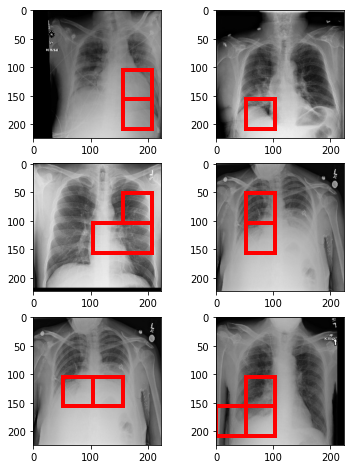

In [ ]:
paint_bbox_pred(val_rec_df.head(6))

### Testing the overall model (both classification and Object detection) on the given test data

In [ ]:
test_images = list(get_files(data_path+"/stage_2_test_images"))

In [ ]:
X_test_set=extract_batch_DICOM_image_Data(test_images,224)

In [ ]:
def pred_test(img_data):
  data_dict = list(img_data.T.to_dict().values())
  fig, ax = plt.subplots(1,1, figsize=(14,8))
  for i, row in enumerate(data_dict):
    img = np.array(img_to_array(load_img(row['img_path'],target_size=(224, 224))).astype('float32'))/255.0
    ax.imshow(img,cmap = plt.cm.bone) # Original Image
    #print('ROI.shape[0]=',R.shape[1])
    #print(row['bboxes']['background'])
    if row['bboxes'].get('Lung Opacity')!=None:
      for j,subrow in enumerate(row['bboxes']['Lung Opacity']):
        #print(subrow)
        #if i==0:
        #x,y,w,h = subrow[0],subrow[1],subrow[2],subrow[3]
        x1,y1,x2,y2 = subrow[0],subrow[1],subrow[2],subrow[3]
        #print(x1,y1,x2,y2)
        rectangle = patches.Rectangle(xy=(x1, y1),
                          width=(x2-x1),height=(y2-y1), 
                          #width=w,height=h,
                          color="yellow",fc='none',ec='r', lw=4)
        ax.add_patch(rectangle)
    
    
  plt.show()

In [ ]:
def classify_pne(X_test_set,model_pne_patient_classifier):
  
  data_dict = list(X_test_set.T.to_dict().values())
  progbar = generic_utils.Progbar(len(X_test_set))
  X_test = pd.DataFrame(columns=['patientId','img_path','classifier'])
  
  for i, row in enumerate(data_dict):
    progbar.update(i)
    img = np.array(img_to_array(load_img(row['image_path'],target_size=(224, 224))).astype('float32'))/255.0
    img = np.expand_dims(img,axis=0)
    #print(img.shape)
    img_classifier= model_pne_patient_classifier.predict(img)
    #print (img_classifier)
    predictions = pred_class(img_classifier)
    new_row = {'patientId': row['patientId'] ,
                     'img_path': row['image_path'],
                       'classifier':predictions.argmax(axis=1)}
    #print(predictions)
    if predictions.argmax(axis=1) ==1:
      X_test = X_test.append(new_row, ignore_index=True)
  return X_test

In [ ]:
model_pne_patient_classifier = load_model(data_path+'/Pneumonia_Classifier_v5.h5')

In [ ]:
best_model_rpn=load_model(data_path+'/Pneumonia_Detector_rpn_v6.h5')

In [ ]:
best_model_classifier=load_model(data_path+'/Pneumonia_Detector_classifier_v6.h5',custom_objects={'RoiPoolingConv': RoiPoolingConv})

In [ ]:
X_test_src_image_folder=data_path+'/stage_2_test_images/'

In [ ]:
X_test_jpg_image_folder=data_path+'/XTest_JPG/'

In [ ]:
X_test_set['image_path']= X_test_set.apply( lambda x: ( X_test_jpg_image_folder+ x["patientId"] + ".jpg" ), axis=1)

In [ ]:
X_pne_test = classify_pne(X_test_set,model_pne_patient_classifier)

2999/3000 [============================>.] - ETA: 0s

In [ ]:
X_pne_test

,patientId,img_path,classifier
0,252386b6-2a6c-4e45-98a7-9af73a1f9b13,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
1,252437ed-a4e2-4743-995c-65a4bb133996,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
2,264d4100-0a4a-460d-81fd-e781bbf6ca86,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
3,260a7b23-08ed-451d-bd0a-ecbffc7c3d30,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
4,26902670-d4e8-44e4-b750-5e95cf9dd3d6,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
...,...,...,...
2995,1a70a918-bcde-4eca-806f-d875867a1a01,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
2996,19fbbcf0-fdc2-4ebd-a921-4bde43188051,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
2997,1530d383-a296-4ad7-bc85-3ccc145e9774,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]
2998,19b8517b-24e4-457b-96c0-a457e30125bb,/content/drive/My Drive/Colab Notebooks/Data/P...,[1]


In [ ]:
objectDetector = objectDetector()

In [ ]:
test_record_df=objectDetector.test_run_model(X_pne_test, best_model_rpn, best_model_classifier)

3000/3000 [==============================] - 4451s 1s/step


In [ ]:
test_record_df

,patientId,img_path,bboxes,elapsed_time
0,252386b6-2a6c-4e45-98a7-9af73a1f9b13,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[104, 52, 156, 156], [52, 52...",0.059
1,252437ed-a4e2-4743-995c-65a4bb133996,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[52, 52, 104, 104], [52, 104...",0.084
2,264d4100-0a4a-460d-81fd-e781bbf6ca86,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[52, 52, 104, 104], [104, 52...",0.109
3,260a7b23-08ed-451d-bd0a-ecbffc7c3d30,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[52, 104, 104, 156], [52, 52...",0.127
4,26902670-d4e8-44e4-b750-5e95cf9dd3d6,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[52, 52, 104, 156], [104, 52...",0.159
...,...,...,...,...
2969,1a70a918-bcde-4eca-806f-d875867a1a01,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[0, 52, 52, 104], [156, 104,...",74.109
2970,19fbbcf0-fdc2-4ebd-a921-4bde43188051,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[52, 52, 104, 104], [104, 52...",74.134
2971,1530d383-a296-4ad7-bc85-3ccc145e9774,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[0, 156, 52, 208], [52, 104,...",74.156
2972,19b8517b-24e4-457b-96c0-a457e30125bb,/content/drive/My Drive/Colab Notebooks/Data/P...,"{'Lung Opacity': [[52, 52, 104, 156], [52, 104...",74.168


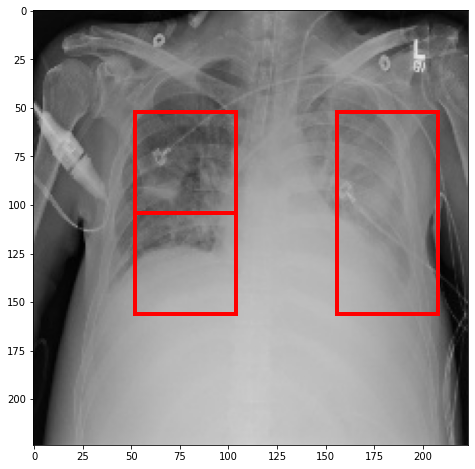

In [ ]:
pred_test(test_record_df.loc[78:78,:])

## Summary
- Solution is two model approach; One for Patient Classification with Pneumonia or normal then Pneumonia detection with bounding boxes & object classification
- Data augmentation with image shaping to 224, image horizontal, vertical flips, rotate by 30 degree, Zoom by 25%
- Decomposed overall training set into batches for incremental training and evaluation
- DICOM images converted into JPG for image processing and array data
- ResNet50v2 used as backbone for Image classification and object detection with transfer learning principles
- Fine tuned based on epochs, learning rates, batch size, data augmentations and loss functions
- FasterRCNN custom development used for Object Detection
- Above 84% achieved for Image classification with accuracy, recall and precision
- Above 70% accuracy for object detection
- Next Steps: 
    - PIPELINE to connect both classifier and object detector models as duo
    - Scanner App for smart devices with models deployed on it, for real-time Pneumonia region detection on Chest X-ray image